# Tracks

## Plotting Functions by MP and LO

In [1]:
### These functions are meant for exporting ATAC data from an ArchR Project, whether into plots or various Bed/BedGraph/BigWig files

library(ArchR)
library(dplyr)
library(tidyverse)
library(plyranges)
library(TxDb.Hsapiens.UCSC.hg38.refGene)
library(doParallel)

#########################  Section 1: Exporting ATAC data into Coverage/Insertions file at single basepair resolution ----


## This will allow for cell-count normalized insertion and coverage file creation.
## Export options

### Here's the pipeline:

### Step 1: Extract fragments by populations from an ArchR Project: getPopFrags()
### Step 2: Export to the file type that you desire
################  FragsToCoverageFiles: Export fragments to BigWig/BedGraph files that contain coverage counts per 1000 cells.
################  FragsToInsertionFiles: Export fragments to BigWig/BedGraph files that contain insertion counts per 1000 cells.


#' Extract fragments by populations from an ArchR Project
#'
#' \code{getPopFrags} returns a list of fragments per cell subset as a GRanges.
#'
#' @param ArchRProj The ArchR Project.
#' @param metaColumn The name of metadata column that contains the populations
#'   of cells you want to merge and export.
#' @param cellSubsets Default is 'ALL'. If you want to export only some groups,
#'   then give it a list of group names. This needs to be unique - no duplicated
#'   names. This list of group names must be identical to names that appear in
#'   the metadata column of the ArchR Project (e.g. metaColumn).
#' @param region Optional parameter. Set this if you only want to extract
#'   fragments from particular regions of the genome. Format should be as a
#'   string (e.g. 'chr1:1000-2000'), or a GRanges object.
#' @param numCores Number of cores to use.
#' @param sampleSpecific Set to TRUE to further subset cells by sample
#' @param NormMethod Normalization method. Can be either "nFrags","nCells", or
#'   "Median".
#' @param blackList Blacklisted region to filter out. Default is to not filter
#'   out anything (i.e. NULL). Input should be provided as a GRanges object. Any
#'   fragments with more than a certain overlap will be thrown out.
#' @param overlapList The minimum overlap necessary for a fragment marked as
#'   overlapping with the blacklist region and thus thrown out.
#'
#' @return A list of GRanges containing fragments. Each GRanges corresponds to a
#'   population defined by cellSubsets (and sample, if
#'   \code{sampleSpecific=TRUE})
#'
getPopFrags <- function(ArchRProj, metaColumn, cellSubsets = "ALL", region = NULL, numCores = 1, sampleSpecific = TRUE,
                        NormMethod = "nfrags", blackList = NULL, overlapList = 50) {
  # Extract metadata
  metadf <- getCellColData(ArchRProj)

  if (!any(colnames(metadf) %in% metaColumn)) {
    stop(paste(
      str_interp("Provided metaColumn ${metaColumn} does not exist in the cellColData of your ArchRProj."),
      str_interp("Available columns are: ${colnames(metadf)}")
    ))
  }

  # Get cell counts for all cell populations
  tmp <- metadf[, metaColumn]
  cellCounts <- table(tmp[!is.na(tmp)])

  if (all(cellSubsets == "ALL")) {
    cellPopulations <- names(cellCounts)
  } else {

    # Take our cell populations from given cellSubsets
    cellPopulations <- unique(cellSubsets[!is.na(cellSubsets)][order(cellSubsets)])

    # Filter cellCounts to selected cell subsets (populations)
    cellCounts <- cellCounts[cellPopulations]
    if (any(is.na(cellCounts))) {
      stop(paste(
        "Some cell populations have NA cell counts.",
        "Please verify that all given cellSubsets exist for the given metaColumn.",
        str_interp("cellSubsets with NA cell counts: ${cellPopulations[is.na(names(cellCounts))]}")
      ))
    }
  }

  if (length(cellCounts) == 0) {
    stop("No cells were found for the given cellSubsets and/or metaColumn.")
  }


  #### Up to here, the above is only specific to sampleSpecific=False
  allArrows <- getArrowFiles(ArchRProj)
  # Get sample names from our populations of interest
  samplesToExtract <- paste(
    unique(metadf$Sample[which(metadf[, metaColumn] %in% cellPopulations)]),
    collapse = "|"
  )
  # Get arrows containing the samples we want
  arrows <- allArrows[grepl(samplesToExtract, allArrows)]

  if (length(arrows) == 0) {
    stop(paste(
      "Found no arrows containing samples from your selected cell subset(s).",
      "Check cellSubsets or the input ArchR Project."
    ))
  }

  if (is.null(region)) {

    # Extract fragments from all available regions
    fragsList <- mclapply(seq_along(arrows), function(x) {
      getFragmentsFromArrow(
        ArrowFile = arrows[x],
        cellNames = NULL,
        verbose = FALSE
      )
    }, mc.cores = numCores)
  } else {

    # Extract fragments from a given region only
    # Validate region and interpret as string or GRanges
    if (validRegionString(region) & tolower(NormMethod) == "raw") {
      regionGRanges <- StringsToGRanges(region)
    } else if (class(region)[1] == "GRanges" & tolower(NormMethod) == "raw") {
      regionGRanges <- region
    } else if (tolower(NormMethod) != "raw") {
      stop(paste(
        "Wrong NormMethod set. Please set NormMethod = 'Raw'",
        "if you wish to extract fragments from a specific region.",
        "\n Alternatively, you can extract the entire genome and then subset."
      ))
    } else {
      stop(paste(
        "Invalid region input.",
        "Region must either be a string matching the format",
        "'seqname:start-end', or a GRanges object."
      ))
    }

    chrom <- regionGRanges %>%
      as.data.frame() %>%
      dplyr::select(seqnames)
    fragsList <- mclapply(seq_along(arrows), function(x) {
      fragsGRanges <- getFragmentsFromArrow(
        ArrowFile = arrows[x],
        cellNames = NULL,
        chr = as.character(chrom[, 1]),
        verbose = FALSE
      ) %>% plyranges::join_overlap_intersect(regionGRanges)

      # Filter according to provided blacklist
      if (is.null(blackList)) {
        fragsGRanges
      } else if (class(blackList)[1] == "GRanges") {
        fragsGRanges %>% plyranges::filter_by_non_overlaps(blackList, minoverlap = overlapList)
      } else {
        stop("Error: Wrong format for blackList region. Please provide GRanges")
      }
    }, mc.cores = numCores)
  }

  # From scMACS - sorts cell barcodes by population
  barcodesByCellPop <- lapply(cellPopulations, function(x) {
    row.names(metadf)[which(metadf[, metaColumn] == x)]
  })

  # Add normalization factor.
  if (tolower(NormMethod) == "raw") {
    names(barcodesByCellPop) <- paste(gsub("#", "_", gsub(" |_", "_", cellPopulations)), 1, sep = "__")
  } else if (tolower(NormMethod) == "ncells") {
    names(barcodesByCellPop) <- paste(gsub("#", "_", gsub(" |_", "_", cellPopulations)), cellCounts / 1000, sep = "__")
  } else if (tolower(NormMethod) == "nfrags") {
    # Calculate the total nFrags for our cell populations
    nFragsNorm <- as.data.frame(metadf[, c(metaColumn, "nFrags")]) %>%
      dplyr::filter(!is.na(get(metaColumn))) %>%
      dplyr::filter(get(metaColumn) %in% cellPopulations) %>%
      dplyr::group_by(get(metaColumn)) %>%
      dplyr::summarize(nFrags = sum(nFrags))

    # Verify expected cellPopulations have corresponding nFrags
    if (!all(nFragsNorm[, 1] == cellPopulations)) {
      print(nFragsNorm[, 1])
      stop("Names of nFrags don't match the cell populations.")
    }
    names(barcodesByCellPop) <- paste(gsub("#", "_", gsub(" |_", "_", cellPopulations)), nFragsNorm$nFrags / 10^6, sep = "__")
  } else if (tolower(NormMethod) == "median") {
    names(barcodesByCellPop) <- paste(gsub("#", "_", gsub(" |_", "_", cellPopulations)), "Median", sep = "__")
  } else if (tolower(NormMethod) == "medmax") {
    names(barcodesByCellPop) <- paste(gsub("#", "_", gsub(" |_", "_", cellPopulations)), "MedianMax", sep = "__")
  } else if (tolower(NormMethod) == "TotalSampleByNCells") {
    # This calculates total fragments per sample.
    totalsampleFrags <- unlist(fragsList, length)
    names(barcodesByCellPop) <- paste(gsub("#", "_", gsub(" |_", "_", cellPopulations)), totalsampleFrags / 10^6 * cellCounts / 1000, sep = "__")
  } else {
    stop("Error: Incorrect NormMethod given.")
  }

  # From scMACS - Function to sort fragments by populations based on cell barcode lists
  subset_Frag <- function(cellNames, fragsGRanges) {
    fragsTable <- as.data.table(fragsGRanges)
    idx <- which(fragsTable$RG %in% cellNames)
    fragsGRanges[idx]
  }

  ## Identify which subset of arrows the population can be found it.
  ## Speeds up sample-specific population extraction
  fragsListIndex <- lapply(cellPopulations, function(x) {
    names(arrows) %in% unique(metadf$Sample[which(metadf[, metaColumn] == x)])
  })

  # Sort fragments into a list by cell population

  popFrags <- lapply(seq_along(barcodesByCellPop), function(x) {
    print(paste("Sorting ", names(barcodesByCellPop)[x], sep = ""))
    if (sum(fragsListIndex[[x]]) > 1) {
      tmp <- mclapply(which(fragsListIndex[[x]]), function(y) {
        subset_Frag(barcodesByCellPop[[x]], fragsList[[y]])
      }, mc.cores = 20)
    } else {
      tmp <- list(subset_Frag(
        barcodesByCellPop[[x]],
        fragsList[[which(fragsListIndex[[x]])]]
      ))
    }

    # For this population, get sample-specific normalization factors
    # and rename the fragment GRanges
    if (sampleSpecific) {
      subSet_tmp <- gsub("__.*", "", names(barcodesByCellPop)[x])

      if (tolower(NormMethod) == "ncells") {
        tmp_cellCount <- unlist(lapply(tmp, function(y) {
          length(unique(y$RG))
        }))

        names(tmp) <- paste(
          subSet_tmp,
          "#",
          names(arrows)[unlist(fragsListIndex[[x]])],
          "__",
          tmp_cellCount / 1000,
          sep = ""
        )
      } else if (tolower(NormMethod) == "nfrags") {
        names(tmp) <- paste(
          subSet_tmp,
          "#",
          names(arrows)[unlist(fragsListIndex[[x]])],
          "__",
          unlist(lapply(tmp, length)) / 10^6,
          sep = ""
        )
      } else {
        subSet_tmp <- gsub("__.*", "", names(barcodesByCellPop)[x])
        norm_tmp <- gsub(".*__", "", names(barcodesByCellPop)[x])

        names(tmp) <- paste(
          subSet_tmp,
          "#",
          names(arrows)[unlist(fragsListIndex[[x]])], "__", norm_tmp,
          sep = ""
        )
      }

      tmp
    } else {
      stack(as(tmp, "GRangesList"))
    }
  })

  if (sampleSpecific) {
    popFrags <- unlist(popFrags, recursive = FALSE)
  } else {
    names(popFrags) <- names(barcodesByCellPop)
  }
  return(popFrags)
}


###### This function take the output from getPopFrags and figures out how to normalize before exporting to the desired file formats.
## popFrags = output from getPopFrags, as a list for the sake of parallelization. The name for each population is populatioName_Norm
## metadata = ArchR metadata
## metaColumn = column in metadata with popFrags
## outDir = the directory to output the resultant fragment files. Optional - default is the current working directory.
FragsToCoverageFiles <- function(popFrags, files = "BigWig", genome = "hg38", sampleAvg = TRUE, fname = NULL, outDir = NULL, numCores = 1) {

  # Extract cell counts for each group
  groups <- gsub("__.*", "", names(popFrags))
  allNorm <- gsub(".*__", "", names(popFrags))
  names(allNorm) <- groups

  # Make bed file names for each group, either with names from popFrags or from the fname list.
  if (is.null(fname) & !sampleAvg) {
    bedFiles <- paste(gsub("-", "_", gsub("/", "_", gsub(" ", "_", groups, fixed = TRUE))), ".bed", sep = "")
  } else if (length(fname) == length(popFrags) & !sampleAvg) {

    # Check if fname is the same length as the popFrags and we're not doing sample Avg
    bedFiles <- paste(fname, ".bed", sep = "")
  } else if (is.null(fname) & sampleAvg & all(grepl("#", names(popFrags)))) {

    # If fname is null and sampleAvg is true, then the popFrags needs to be formated for sample-specific coverage.

    uniqueGroups <- unique(gsub("#.*", "#", names(popFrags)))
    bedFiles <- paste(gsub("-", "_", gsub("/", "_", gsub(" ", "_", groups, fixed = TRUE))), ".bed", sep = "")
  } else if (length(fname) == length(unique(gsub("#.*", "#", names(popFrags)))) & sampleAvg & all(grepl("#", names(popFrags)))) {

    # If we want to rename the sample average, then fname needs to be the same length as the number of unique groups.

    uniqueGroups <- unique(gsub("#.*", "#", names(popFrags)))
    bedFiles <- paste(fname, ".bed", sep = "")
  } else if (sampleAvg == TRUE & !all(grepl("#", names(popFrags)))) {
    stop("Error: You asked for exporting sample averages for all cell groups, but didn't provide sample-specific fragment lists.
		Please re-run getPopFrags with sampleSpecific = TRUE")
  } else {
    stop("Error: fname parameter is not the same length as the number of populations you want to export.")
  }
  # Prepend output directory (if given) to file names
  if (!is.null(outDir)) {
    dir.create(outDir, recursive = TRUE)
    bedFiles <- file.path(outDir, bedFiles)
  }

  # Test export options for bed and bam files
  if (all(tolower(files) == "all" & !sampleAvg)) {

    # Export to BAM
    writeBAMHelper(popFrags, bedFiles, genome, numCores)
    # Export data from GRanges to bed
    mclapply(seq_along(popFrags), function(x) {
      # Export to bed
      plyranges::write_bed(popFrags[[x]], bedFiles[x])
    }, mc.cores = numCores)
  } else if (any(tolower(files) == "bed" & !sampleAvg)) {

    # Export data from GRanges to bed files, and end the function.
    mclapply(seq_along(popFrags), function(x) {
      plyranges::write_bed(popFrags[[x]], bedFiles[x])
    }, mc.cores = numCores)
    return()
  } else if (any(tolower(files) == "bam" & !sampleAvg)) {
    # Export to BAM, and end the function
    writeBAMHelper(popFrags, bedFiles, genome, numCores)
    return()
  }

  ### Let's generate coverage files within R,


  # If you want to take the sample average across a group

  if (sampleAvg == TRUE & all(grepl("#", names(popFrags)))) {
    mclapply(seq_along(uniqueGroups), function(x) {
      print(paste("Summarizing", uniqueGroups[x], sep = ""))

      # Iterate along all samples for this population, calculating the coverage, and then turn the GRanges into a data.table
      # After which, we bind those data.tables together, and turn it back into a GRanges object.
      # This might seem ineffecient, but computationally, it's faster and less prone to error as plyranges is actively being developed.

      if (grepl("Median|Max|MedMax", allNorm[x])) {

        # Iterate along all the samples of this cell group.
        tmp1 <- lapply(seq_along(which(grepl(uniqueGroups[x], names(popFrags)))), function(y) {
          tmp_Cov <- plyranges::compute_coverage(popFrags[[y]])

          medCov <- tmp_Cov %>%
            plyranges::filter(score != 0) %>%
            plyranges::tile_ranges(., width = 1)

          maxScore <- max(tmp_Cov$score[medCov$partition])
          medScore <- median(tmp_Cov$score[medCov$partition])
          medMax <- max(tmp_Cov$score[medCov$partition] / medScore)

          tmp_Cov %>%
            plyranges::mutate(Norm = rep(NormVal, n = plyranges::n())) %>%
            plyranges::mutate(score = case_when(
              grepl("Median", Norm) ~ score / medScore,
              grepl("Max", Norm) ~ score / maxScore,
              grepl("MedMax", Norm) ~ score / medMax,
              TRUE ~ score / as.numeric(Norm)
            )) %>% # Redundant/safety measure. Should not be triggered.
            as.data.table()


          tmp_Cov
        }) %>%
          rbindlist() %>%
          makeGRangesFromDataFrame(., keep.extra.columns = TRUE)
      } else {
        tmp1 <- lapply(seq_along(which(grepl(uniqueGroups[x], names(popFrags)))), function(y) {

          # Compute coverage for each sample, and normalize by the normalization factor.

          NormVal <- unique(gsub(".*__", "", names(popFrags)[y]))
          plyranges::compute_coverage(popFrags[[y]]) %>%
            plyranges::mutate(name = names(popFrags)[y]) %>%
            plyranges::mutate(score = score / as.numeric(NormVal)) %>%
            as.data.table()
        }) %>%
          rbindlist() %>%
          makeGRangesFromDataFrame(., keep.extra.columns = TRUE)
      }

      sampleNum <- sum(grepl(uniqueGroups[x], names(popFrags)))
      popCov <- tmp1 %>% disjoin_ranges(score = sum(score) / sampleNum)
      # return(popCov)
      exportCov(
        CovObject = popCov, files = files,
        fileName = gsub("#", "", uniqueGroups[x])
      )
    }, mc.cores = numCores)
  } else {
    mclapply(seq_along(popFrags), function(x) {
      print(paste("Summarizing ", gsub("__.*", "", bedFiles[x]), sep = ""))

      tmp1 <- plyranges::compute_coverage(popFrags[[x]])

      if (grepl("Median|Max|MedMax", allNorm[x])) {
        medCov <- tmp1 %>%
          plyranges::filter(score != 0) %>%
          plyranges::tile_ranges(., width = 1)

        maxScore <- max(tmp1$score[medCov$partition])
        medScore <- median(tmp1$score[medCov$partition])
        medMax <- max(tmp1$score[medCov$partition] / medScore)

        popCov <- tmp1 %>%
          plyranges::mutate(Norm = rep(allNorm[[x]], n = plyranges::n())) %>%
          plyranges::mutate(score = case_when(
            grepl("Median", Norm) ~ score / medScore,
            grepl("Max", Norm) ~ score / maxScore,
            grepl("MedMax", Norm) ~ score / medMax,
            TRUE ~ score / as.numeric(Norm)
          )) %>%
          plyranges::mutate(score = ifelse(grepl("MedMax", Norm), score / medMax))
      } else {
        popCov <- tmp1 %>%
          plyranges::mutate(Norm = rep(allNorm[[x]], n = plyranges::n())) %>%
          plyranges::mutate(score = score / as.numeric(Norm))
      }

      exportCov(
        CovObject = popCov, files = files,
        fileName = gsub(".bed", "", bedFiles[x])
      )
    }, mc.cores = numCores)
  }
}


### Similar function to above, except will export insertion counts.
FragsToInsertionFiles <- function(popFrags, files = "bw", genome = "hg38", fname = NULL, outDir = NULL, numCores = 1) {

  # Double check inputs: Are the files that we need actually present?

  # Extract cell counts for each group
  groups <- gsub("__.*", "", names(popFrags))
  allNorm <- gsub(".*__", "", names(popFrags))
  names(allNorm) <- groups

  ## Let's extract Insertion sites
  popIns <- mclapply(seq_along(popFrags), function(x) {
    cutstart <- GRanges(seqnames = as(seqnames(popFrags[[x]]), "vector"), ranges = IRanges(start = start(popFrags[[x]]), width = 1), strand = "*")
    cutend <- GRanges(seqnames = as(seqnames(popFrags[[x]]), "vector"), ranges = IRanges(start = end(popFrags[[x]]), width = 1), strand = "*")
    plyranges::bind_ranges(cutstart, cutend)
  }, mc.cores = numCores)
  names(popIns) <- names(popFrags)


  # Make bed file names for each group, either with names from popFrags or from the fname list.
  if (is.null(fname)) {
    bedFiles2 <- paste(gsub("-", "_", gsub("/", "_", gsub(" ", "_", groups, fixed = TRUE))), "_insertions.bed", sep = "")
  } else if (length(fname) == length(popFrags)) {
    bedFiles2 <- paste(fname, "_insertions.bed", sep = "")
  } else {
    stop("Error: fname parameter is not the same length as popFrags")
  }
  # Prepend output directory (if given) to file names
  if (!is.null(outDir)) {
    dir.create(outDir, recursive = TRUE)
    bedFiles2 <- file.path(outDir, bedFiles2)
  }

  if (all(tolower(files) == "all")) {


    # Export to BAM
    writeBAMHelper(popIns, bedFiles2, genome, numCores)
    # Export data from GRanges to bed files
    # Then move onto export the rest
    mclapply(seq_along(popIns), function(x) {
      plyranges::write_bed(popIns[[x]], bedFiles2[x])
    }, mc.cores = numCores)
  } else if (any(tolower(files) == "bed")) {

    # Export data from GRanges to bed files, and end the function.
    mclapply(seq_along(popIns), function(x) {
      plyranges::write_bed(popIns[[x]], bedFiles2[x])
    }, mc.cores = numCores)
    return()
  } else if (any(tolower(files) == "bam")) {

    # Export to BAM, and end the function
    writeBAMHelper(popIns, bedFiles2, genome, numCores)
    return()
  }


  # Export to bigwigs or bed graphs.

  # If you want to take the sample average across a group

  if (sampleAvg == TRUE & all(grepl("#", names(popIns)))) {
    uniqueGroups <- unique(gsub("#.*", "#", names(popIns)))


    mclapply(seq_along(uniqueGroups), function(x) {
      print(paste("Summarizing", uniqueGroups[x], sep = ""))

      # Iterate along all samples for this population, calculating the coverage, and then turn the GRanges into a data.table
      # After which, we bind those data.tables together, and turn it back into a GRanges object.
      # This might seem ineffecient, but computationally, it's faster and less prone to error as plyranges is actively being developed.

      if (grepl("Median|Max|MedMax", allNorm[x])) {

        # Iterate along all the samples of this cell group.
        tmp1 <- lapply(seq_along(which(grepl(uniqueGroups[x], names(popIns)))), function(y) {
          tmp_Cov <- plyranges::compute_coverage(popIns[[y]])

          medCov <- tmp_Cov %>%
            plyranges::filter(score != 0) %>%
            plyranges::tile_ranges(., width = 1)

          maxScore <- max(tmp_Cov$score[medCov$partition])
          medScore <- median(tmp_Cov$score[medCov$partition])
          medMax <- max(tmp_Cov$score[medCov$partition] / medScore)

          tmp_Cov %>%
            plyranges::mutate(Norm = rep(NormVal, n = plyranges::n())) %>%
            plyranges::mutate(score = case_when(
              grepl("Median", Norm) ~ score / medScore,
              grepl("Max", Norm) ~ score / maxScore,
              grepl("MedMax", Norm) ~ score / medMax,
              TRUE ~ score / as.numeric(Norm)
            )) %>% # Redundant/safety measure. Should not be triggered.
            as.data.table()


          tmp_Cov
        }) %>%
          rbindlist() %>%
          makeGRangesFromDataFrame(., keep.extra.columns = TRUE)
      } else {
        tmp1 <- lapply(seq_along(which(grepl(uniqueGroups[x], names(popIns)))), function(y) {

          # Compute coverage for each sample, and normalize by the normalization factor.

          NormVal <- unique(gsub(".*__", "", names(popIns)[y]))
          plyranges::compute_coverage(popIns[[y]]) %>%
            plyranges::mutate(name = names(popIns)[y]) %>%
            plyranges::mutate(score = score / as.numeric(NormVal)) %>%
            as.data.table()
        }) %>%
          rbindlist() %>%
          makeGRangesFromDataFrame(., keep.extra.columns = TRUE)
      }

      popCov <- tmp1 %>% disjoin_ranges(score = sum(score) / sum(grepl(uniqueGroups[x], names(popIns))))

      exportCov(
        CovObject = popCov, files = files,
        fileName = gsub("#", "", uniqueGroups[x])
      )
    }, mc.cores = numCores)
  } else if (sampleAvg == TRUE) {
    stop("Error: You asked for exporting sample averages for all cell groups, but didn't provide sample-specific fragment lists. Please re-run getPopFrags with sampleSpecific = TRUE")
  } else {
    mclapply(seq_along(popIns), function(x) {
      print(paste("Exporting ", gsub(".bed", "", bedFiles2[x]), sep = ""))
      tmp1 <- plyranges::compute_coverage(popIns[[x]])

      if (grepl("Median|Max|MedMax", allNorm[x])) {
        medCov <- tmp1 %>%
          plyranges::filter(score != 0) %>%
          plyranges::tile_ranges(., width = 1)

        maxScore <- max(tmp1$score[medCov$partition])
        medScore <- median(tmp1$score[medCov$partition])
        medMax <- max(tmp1$score[medCov$partition] / medScore)

        popCov <- tmp1 %>%
          plyranges::mutate(Norm = rep(allNorm[[x]], n = plyranges::n())) %>%
          plyranges::mutate(score = case_when(
            grepl("Median", Norm) ~ score / medScore,
            grepl("Max", Norm) ~ score / maxScore,
            grepl("MedMax", Norm) ~ score / medMax,
            TRUE ~ score / as.numeric(Norm)
          )) %>%
          plyranges::mutate(score = ifelse(grepl("MedMax", Norm), score / medMax))
      } else {
        popCov <- tmp1 %>%
          plyranges::mutate(Norm = rep(allNorm[[x]], n = plyranges::n())) %>%
          plyranges::mutate(score = score / as.numeric(Norm))
      }

      exportCov(
        CovObject = popCov, files = files,
        fileName = gsub(".bed", "_Insertions", bedFiles2[x])
      )
    }, mc.cores = numCores)
  }
}


#' Get basepair-resolution fragments coverage or insertion counts
#'
#' \code{getbpCounts} Returns a GRanges or data frame containing single-basepair
#' resolution scores on the given fragments.
#'
#' @param regionString The region from which to extract basepair counts. Format
#'   should be as a string (e.g. 'chr1:1000-2000')
#' @param popFrags Fragments from \code{getPopFrags}
#' @param numCores Number of cores to use.
#' @param returnGRanges Set TRUE to return coverage as a GRanges, else default
#'   behavior is to return a data frame
#' @param sampleAvg Set to TRUE to take the sample average across a group. This
#'   only works if \code{popFrags} was generated with \code{sampleSpecific=TRUE}
#' @param approxLimit Max size of region in basepairs before binning is used.
#' @param binSize Size of bins to use when binning
#'
#' @return A GRanges or Data Frame containing basepair resolution fragment or
#'   insertion counts. If \code{sampleAvg=TRUE} these counts will be averaged
#'   over all samples within a population. If the region given by regionString
#'   exceeds the size of approxLimit, counts will be aggregated into bins of
#'   size binSize bp.
getbpCounts <- function(regionString, popFrags, numCores,
                        returnGRanges = FALSE, sampleAvg = TRUE,
                        approxLimit = 100000, binSize = 250) {

  # Parse through region
  regionString <- gsub(",", "", regionString, fixed = TRUE)
  chrom <- gsub(":.*", "", regionString)
  startSite <- gsub(".*:", "", regionString) %>%
    gsub("-.*", "", .) %>%
    as.numeric()
  endSite <- gsub(".*-", "", regionString) %>% as.numeric()

  regionGRanges <- GRanges(seqnames = chrom, ranges = IRanges(start = startSite, end = endSite), strand = "*")

  # Extract cell counts for each group
  groups <- gsub("__.*", "", names(popFrags))
  Norm <- gsub(".*__", "", names(popFrags))
  names(Norm) <- groups

  # Determine if binning is needed to simplify things
  if (endSite - startSite > approxLimit) {
    print(str_interp("Size of region exceeds ${approxLimit}bp. Binning data over ${binSize}bp windows."))
    binnedData <- regionGRanges %>%
      tile_ranges(., binSize) %>%
      mutate(idx = c(1:length(.)))
  }

  # Summarize the coverage over the region window at a single basepair resolution
  tmpCounts <- mclapply(seq_along(groups), function(x) {
    print(paste("Counting", names(popFrags)[x], sep = " "))

    Num <- as.numeric(Norm[groups[x]])
    tmpGR <- plyranges::compute_coverage(popFrags[[x]]) %>%
      plyranges::mutate(score = score / Num) %>%
      plyranges::filter_by_overlaps(regionGRanges)

    # If we are binning, average scores over each bin
    if (endSite - startSite > approxLimit) {
      tmpGR <- plyranges::join_overlap_intersect(tmpGR, binnedData) %>%
        plyranges::group_by(idx) %>%
        plyranges::reduce_ranges(score = mean(score)) %>%
        ungroup()
    }

    tmpGR
  }, mc.cores = numCores)
  names(tmpCounts) <- groups


  if (all(lapply(seq_along(tmpCounts), function(x) {
    sum(tmpCounts[[x]]$score) == 0
  }))) {
    stop("Error: No fragments detected in this region")
  }


  # If you want to take the sample average across a group

  if (sampleAvg == TRUE & all(grepl("#", names(popFrags)))) {
    groupCounts <- stack(as(lapply(tmpCounts, setSeqInfo), "GRangesList")) %>%
      plyranges::mutate(Group = gsub("#.*", "", name)) %>%
      S4Vectors::split(., .$Group)

    tmpCounts <- lapply(groupCounts, function(x) {
      sampleCount <- length(unique(x$name))
      x %>%
        plyranges::compute_coverage(weight = .$score / sampleCount) %>%
        plyranges::filter_by_overlaps(regionGRanges)
    })
    names(tmpCounts) <- names(groupCounts)
  } else if (sampleAvg == TRUE) {
    stop("Error: You asked for exporting sample averages for all cell groups, but didn't provide sample-specific fragment lists.
		Please re-run getPopFrags with sampleSpecific = TRUE")
  }

  if (returnGRanges) {
    return(tmpCounts)
  }

  groups <- names(tmpCounts)


  ## Generate a data.frame for export.
  allTmp <- mclapply(seq_along(tmpCounts), function(x) {
    tmpdf <- as.data.frame(tmpCounts[[x]])
    if (dim(tmpdf)[1] < 2 & endSite - startSite <= approxLimit) {
      data.frame(
        chr = rep(chrom, (endSite - startSite + 1)),
        Locus = c(startSite:endSite),
        Counts = rep(0, (endSite - startSite + 1)),
        CellType = rep(groups[x], (endSite - startSite + 1))
      )

      print(paste(groups[x], " has no coverage for this region", sep = ""))
    } else if (dim(tmpdf)[1] < 2 & endSite - startSite > approxLimit) {

      # If you bin data, then you need to set the Locus as the middle of the GRanges.
      # This is only an issue if you aren't doing bp-specific coverage.
      # In this case, if a given group has no coverage, then we create an empty
      # data.frame for that group, using the midpoint of the whole region.
      as_tibble(binnedData) %>%
        dplyr::mutate(Groups = groups[x]) %>%
        mutate(
          Locus = as.integer((start + end) / 2),
          Counts = 0,
          chr = seqnames
        ) %>%
        dplyr::select(chr, Locus, Counts, Groups) %>%
        dplyr::filter(Locus >= startSite & Locus <= endSite)

      print(paste(groups[x], " has no coverage for this region", sep = ""))
    } else if (endSite - startSite > approxLimit) {

      # If you bin data, then you need to set the Locus as the middle of the GRanges.
      # This is only an issue if you aren't doing bp-specific coverage.

      as_tibble(tmpdf) %>%
        dplyr::mutate(Groups = groups[x]) %>%
        mutate(
          Locus = as.integer((start + end) / 2),
          Counts = score,
          chr = seqnames
        ) %>%
        dplyr::select(chr, Locus, Counts, Groups) %>%
        dplyr::filter(Locus >= startSite & Locus <= endSite)
    } else {
      tmp <- tmpCounts[[x]] %>% plyranges::tile_ranges(width = 1)
      tmp$score <- tmpCounts[[x]]$score[tmp$partition]
      tmp$Groups <- rep(groups[x], length(tmp))

      covdf <- as.data.frame(tmp) %>% dplyr::select(seqnames, start, score, Groups)
      colnames(covdf) <- c("chr", "Locus", "Counts", "Groups")

      covdf %>% dplyr::filter(Locus >= startSite & Locus <= endSite)
    }
  }, mc.cores = numCores)

  tmpCountsdf <- as.data.frame(data.table::rbindlist(allTmp))

  return(tmpCountsdf)
}

# same function as above but for insertions
# This calculates bp counts over a region, scaled per 1000 cells
# regionString = region that you want to plot, e.g. chr1:10000-20000
# frags = list of fragments by group, derived from getPopFrags
# numCores for multithreading

getbpInserts <- function(regionString, popFrags, numCores = 1, sampleAvg = TRUE) {

  # Parse through region
  chrom <- gsub(":.*", "", regionString)
  startSite <- gsub(".*:", "", regionString) %>%
    gsub("-.*", "", .) %>%
    as.numeric()
  endSite <- gsub(".*-", "", regionString) %>% as.numeric()

  regionGRanges <- GRanges(seqnames = chrom, ranges = IRanges(start = startSite, end = endSite), strand = "*")

  # Extract cell counts for each group
  groups <- gsub("__.*", "", names(popFrags))
  Norm <- gsub(".*__", "", names(popFrags))
  names(Norm) <- groups

  tmpCounts <- lapply(c(1:length(popFrags)), function(x) {
    print(paste("Counting insertions sites for ", names(popFrags)[x], sep = " "))
    # Pull out insertion sites - start and end
    cutstart <- GRanges(seqnames = as(seqnames(popFrags[[x]]), "vector"), ranges = IRanges(start = start(popFrags[[x]]), width = 1), strand = "*")
    cutend <- GRanges(seqnames = as(seqnames(popFrags[[x]]), "vector"), ranges = IRanges(start = end(popFrags[[x]]), width = 1), strand = "*")
    tmp_inserts <- plyranges::bind_ranges(cutstart, cutend)

    # now iterate over region, looking at overlap with insertion sites
    tmp <- unlist(mclapply(c(1:(endSite - startSite + 1)), function(i) {
      singlebp <- GRanges(seqnames = chrom, ranges = IRanges(start = startSite + i, end = startSite + i), strand = "*")
      bpRegion <- tmp_inserts %>% plyranges::join_overlap_intersect(singlebp)
      length(bpRegion)
    }, mc.cores = numCores))

    Num <- as.numeric(Norm[groups[x]])
    tmp / Norm
  })
  names(tmpCounts) <- groups
  tmpdf <- as.data.frame(tmpCounts)
  tmpdf$Locus <- c(startSite:endSite)

  # Create a table of counts data by Celltype, and basepair, with a column for the Chromosome name.
  tmpCountsdf <- tmpdf %>%
    tidyr::pivot_longer(cols = colnames(.)[colnames(.) != "Locus"], names_to = "Groups", values_to = "Counts") %>%
    dplyr::mutate(chr = rep(chrom, dim(.)[1]))


  # If you want to take the sample average across a group

  if (sampleAvg == TRUE & all(grepl("#", names(popFrags)))) {
    AvgCountsdf <- tmpCountsdf %>%
      dplyr::mutate(Groups = gsub("#.*", "", Groups)) %>%
      group_by(Groups, chr, Locus) %>%
      dplyr::summarize(Counts = mean(Counts))

    return(AvgCountsdf)
  } else if (sampleAvg == TRUE) {
    stop("Error: You asked for exporting sample averages for all cell groups, but didn't provide sample-specific fragment lists.
		Please re-run getPopFrags with sampleSpecific = TRUE")
  } else {
    return(tmpCountsdf)
  }
}


### Quick support functions for section 1 ---

### Function to set seqinfo for GRanges objects.
### This makes them easier to merge and export to BWs by setting the standard
### chromosome lengths and names to a standard, as defined by TxDb.

setSeqInfo <- function(GRangesObj, TxDb = TxDb.Hsapiens.UCSC.hg38.refGene) {
  seqinfo(GRangesObj) <- seqinfo(TxDb)[seqnames(seqinfo(GRangesObj))]
  return(GRangesObj)
}


## Export plyranges to various coveragefile formats

exportCov <- function(CovObject, files, fileName, Txdb = TxDb.Hsapiens.UCSC.hg38.refGene) {

  ### Let's exporting them to Bigwigs and/or bedgraphs

  CovObject <- setSeqInfo(CovObject, Txdb)

  print(paste("Exporting ", fileName, sep = ""))

  if (all(tolower(files) == "all")) {

    # Export BigWigs and BedGraphs

    plyranges::write_bed_graph(CovObject, paste(fileName, ".bedGraph", sep = ""))
    plyranges::write_bigwig(CovObject, paste(fileName, ".bw", sep = ""))
  } else if (any(tolower(files) == "bigwig")) {

    # Export Bigwigs only
    plyranges::write_bigwig(CovObject, paste(fileName, ".bw", sep = ""))
  } else if (any(tolower(files) == "bedgraph")) {

    # Export Bedgraphs only
    plyranges::write_bed_graph(CovObject, paste(fileName, ".bedGraph", sep = ""))
  } else {
    break("Error: Incorrect export option give. Check inputs")
  }
}

validRegionString <- function(regionString) {
  if (!is.character(regionString)) {
    return(FALSE)
  }

  pattern <- "([0-9]{1,2}|chr[0-9]{1,2}):[0-9]*-[0-9]*"
  matchedPattern <- str_extract(regionString, pattern)

  if (is.na(matchedPattern)) {
    return(FALSE)
  } else if (!matchedPattern == regionString) {
    return(FALSE)
  }

  splits <- str_split(regionString, "[:-]")[[1]]
  start <- splits[2]
  end <- splits[3]
  if (start > end) {
    return(FALSE)
  }

  # All conditions satisfied
  return(TRUE)
}

StringsToGRanges <- function(regionString) {
  if (!validRegionString(regionString)) {
    stop("Region must be a string matching format 'seqname:start-end', where start<end e.g. chr1:123000-123500")
  }

  chrom <- gsub(":.*", "", regionString)
  startSite <- gsub(".*:", "", regionString) %>%
    gsub("-.*", "", .) %>%
    as.numeric()
  endSite <- gsub(".*-", "", regionString) %>% as.numeric()


  regionGRanges <- GRanges(seqnames = chrom, ranges = IRanges(start = startSite, end = endSite), strand = "*")
  return(regionGRanges)
}

# Helper function to process and write to BAM
writeBAMHelper <- function(popFrags, bedFiles, genome, numCores) {

  # Coerce 'names' of popFrags to <character> for BamFile conversion"
  if ("name" %in% colnames(popFrags)) {
    popFrags <- mclapply(seq_along(popFrags), function(x) {
      if ("name" %in% colnames(popFrags)) {
        popFrags[[x]] <- transform(popFrags[[x]], name = as.character(name))
      }
    }, mc.cores = numCores)
  }

  ## Fetch chromInfo file from UCSC for given genome, "hg38" default.
  ## This uses fetchExtendedChromInfoFromUCSC() behind the scenes and
  ## requires internet access. See ?fetchExtendedChromInfoFromUCSC
  ## for the list of UCSC genomes that are currently supported.
  chromInfo <- Seqinfo(genome = genome)

  # Change bedFiles extensions to .bam
  bamFiles <- gsub(".bed", ".bam", bedFiles)

  # Export data from GRanges to bam files, and end the function.
  mclapply(seq_along(popFrags), function(x) {
    # Export to bed
    plyranges::write_bed(popFrags[[x]], bedFiles[x])

    # Convert to GAlignments
    popGAlignments <- as(popFrags[[x]], "GAlignments")

    # Add seqinfo
    chrNames <- names(seqlengths(popGAlignments))
    seqinfo(popGAlignments) <- chromInfo[chrNames]

    # Remove metadata cols
    mcols(popGAlignments) <- NULL

    # Export to BAM
    rtracklayer::export(popGAlignments, bamFiles[x])
  }, mc.cores = numCores)
}


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
######################### Section 2: Plotting Coverge and Insertion data for specific regions ----
library(dplyr)
library(tidyverse)
library(plyranges)
library(ggrepel)
library(ggbio)
library(TxDb.Hsapiens.UCSC.hg38.refGene)
library(org.Hs.eg.db)
library(OrganismDbi)
library(doParallel)



## Work Flow:
#### 1. Pull out fragments for a given region by group - getPopFrags, from ArchR_Export_ATAC_Data.R
######### source('ArchR_Export_ATAC_Data.R")
#### 2. Summarize the bp counts for either coverage or insertions, normalized per thousand cells
#### 3. Plot coverage or insertions, with motif positions overlaid.


# This calculates bp counts over a region, scaled per 1000 cells
# region = region that you want to plot
# regionString = region that you want to plot, e.g. chr1:10000-20000
# numCores for multithreading


##### supporting functions for plotRegion
# Modified Track Plots

#' Get gene promoter range string
#'
#' For a given gene, return the gene position from an ArchR project    
#' 
#' @param proj An ArchR Project
#' @param gene The name of a gene
#' @param upstream The number of basepairs to extend the range upstream of the gene promoter
#' @param downstream The number of basepairs to extend the range downstream of the gene promoter
#' @param output_string Logical value, default TRUE. If TRUE outputs a range string (ie 'chr1: 1700000-1710000') else
#' outputs a granges object
#' 
#' @return A range string or granges object, depending on 'output_string' parameter.
get_promoter_range <- function(proj, gene, upstream = 50000, downstream = 50000, output_string = TRUE) {
  gene_pos <- ArchR::getGenes(proj, gene)
  pro_pos_gr <- GenomicRanges::promoters(gene_pos, upstream = upstream, downstream = downstream)
  if (output_string) {
    pro_pos_str <- sprintf(
      "%s: %s-%s",
      GenomicRanges::seqnames(pro_pos_gr),
      GenomicRanges::start(GenomicRanges::ranges(pro_pos_gr)),
      GenomicRanges::end(GenomicRanges::ranges(pro_pos_gr))
    )
    return(pro_pos_str)
  } else {
    return(pro_pos_gr)
  }
}

#' CountDF to Region GRanges
#'
#' Gets the range covered by counts in a count df and converts to granges
#' Used in `plotRegion()`
#'
#' @param countdf  A dataframe that comes from `getbpCounts()` or `getbpInserts()`. Expected columns "chr" and "Locus"
#' @return A granges object for the region defined in countdf
countdf_to_region <- function(countdf) {
  assertthat::assert_that("chr" %in% names(countdf))
  assertthat::assert_that("Locus" %in% names(countdf))
  
  chrom <- toString(unique(countdf$chr))
  startSite <- min(countdf$Locus)
  endSite <- max(countdf$Locus)
  regionGRanges <- GenomicRanges::GRanges(
    seqnames = chrom,
    ranges = IRanges::IRanges(start = startSite, end = endSite), strand = "*"
  )
  
  return(regionGRanges)
}

#' Get GeneBody GRanges for a given region
#'
#' Used in `plotRegion()`
#'
#' @param regionGRanges regionGRanges A region Granges object to retrieve gene bodies for. For example, the output of countdf_to_region.
#' @param TxDb A TxDb database, default TxDb.Hsapiens.UCSC.hg38.refGene
#' @param single.strand.genes.only Logical, default FALSE.
get_grange_genebody <- function(regionGRanges, TxDb = TxDb.Hsapiens.UCSC.hg38.refGene, single.strand.genes.only = FALSE) {
  geneBody <- GenomicFeatures::genes(TxDb, single.strand.genes.only = single.strand.genes.only) %>%
    unlist() %>%
    plyranges::join_overlap_intersect(regionGRanges)
  return(geneBody)
}


#' Default ggplot theme for counts plot
.counts_plot_default_theme <- list(
  panel.grid = element_blank(),
  plot.margin = unit(c(0, 0, 0, 0), "cm"),
  legend.title = element_text(size = 12),
  legend.text = element_text(size = 10),
  axis.text.y = element_blank(),
  axis.ticks.y = element_blank(),
  panel.border = element_blank(),
  strip.background = element_blank(),
  strip.text.x = element_text(size = 10, angle = 0),
  strip.text.y = element_text(size = 10, angle = 0)
)


#' Plot normalized counts for each sample
#'
#' Used in `plotRegion()` for the counts tracks
#'
#' @param countdf  A dataframe that comes from `getbpCounts()` or `getbpInserts()`
#' @param plotType Options include 'overlaid','stacked', or 'RidgePlot'. default is 'stacked', which will plot a seperate track for each group. 
#' Setting plotType to 'overlaid' will overlay count plot histograms across samples, instead of faceting out separately.
#' Setting plotType to 'RidgePlot' will generate a ridgeplot across all groups. 
#' @param base_size Numeric, default 12. Global plot base text size parameter
#' @param counts_color Optional color palette. A named vector of color values where names are unique values in the `color_var` column
#' @param range_label_size Numeric value, default 4. Text size for the y-axis range label
#' @param legend.position Any acceptable `legend.position` argument to theme(). Default NULL will place legend for overlaid plots at (0.8,0.8),
#' or to the "right" for faceted plots.
#' @param facet_label_side Direction character value, default "top". Can also be "right", "left", or "bottom". Position of facet label.
#' @param counts_group_colors Optional named color vector. Values as colors, names are levels of `counts_color_var`. If provided, will color the plots specifically
#' using `scale_color_manual()`
#' @param counts_color_var Character value, default "Groups". Column name from countdf to use to color counts plots.
#' Only used if counts_group_colors provided
#' @param theme_ls A list of named theme arguments passed to theme(), defaults to `.counts_plot_default_theme`. For example, `list(axis.ticks = element_blank())`
#' @return A ggplot object of count histograms by sample.

counts_plot_samples <- function(countdf,
                                plotType = 'stacked',
                                base_size = 12,
                                counts_color = NULL,
                                range_label_size = 4,
                                legend.position = NULL,
                                facet_label_side = "top",
                                counts_group_colors = NULL,
                                counts_color_var = "Groups",
                                theme_ls = .counts_plot_default_theme) {
  assertthat::assert_that("Counts" %in% names(countdf))
  assertthat::assert_that("Locus" %in% names(countdf))
  assertthat::assert_that("Groups" %in% names(countdf))
  assertthat::assert_that(counts_color_var %in% names(countdf))
  
  # Fill in theme any unspecified theme options with defaults
  default_theme <- .counts_plot_default_theme
  unspec_param <- setdiff(names(default_theme), names(theme_ls))
  if (length(unspec_param) > 0) {
    theme_ls <- c(theme_ls, default_theme[unspec_param])
  }
  
  # Range df for plotting
  df_range <- data.frame(
    x = max(countdf$Locus),
    y = max(countdf$Counts),
    label = paste0("Range:", 0, "-", round(max(countdf$Counts), digits = 2))
  )
  
  # Intialize plot
  p1 <- ggplot(data = countdf, aes(x = Locus, y = Counts)) +
    theme_bw(base_size = base_size)
  
  
  # Plots
  if (tolower(plotType) == 'overlaid') {
    # Conditional Theme
    if (is.null(legend.position)) {
      legend.position <- c(0.8, 0.8)
    }
    theme_ls <- c(
      theme_ls,
      list(
        legend.position = legend.position
      )
    )
    
    # Base Plot
    p1 <- p1 +
      geom_line(aes(color = !!as.name(counts_color_var)), alpha = 0.75, size = 1.5) +
      ylab(NULL) +
      labs(Groups = "Groups") +
      coord_cartesian(clip = "off") +
      geom_text(
        data = df_range,
        aes(x = x, y = y, label = label),
        size = range_label_size,
        hjust = 1,
        vjust = 1
      ) +
      do.call(theme, theme_ls)
    
    # Conditional Plot Elements
    if (!is.null(counts_group_colors)) {
      # assertthat::assert_that(all(unique(countdf[[counts_color_var]]) %in% names(counts_group_colors)),
      #                        msg = "Must supply colors for all levels of color variable")
      p1 <- p1 + scale_color_manual(values = counts_group_colors, breaks = names(counts_group_colors))
    }
  } else if(tolower(plotType) == 'stacked'){
    # Conditional Theme
    if (is.null(legend.position)) {
      legend.position <- "right"
    }
    theme_ls <- c(
      theme_ls,
      list(
        legend.position = legend.position
      )
    )
    
    # Base Plot, conditional
    if (is.null(counts_color)) {
      p1 <- p1 +
        geom_area(aes(fill = !!as.name(counts_color_var)), position = "identity")
    } else {
      p1 <- p1 +
        geom_area(fill = counts_color, position = "identity")
    }
    
    # Base Plot, common elements
    p1 <- p1 +
      ylab(NULL) +
      facet_wrap(vars(Groups), ncol = 1, strip.position = facet_label_side) +
      geom_text(
        data = df_range,
        aes(x = x, y = y, label = label),
        size = range_label_size,
        hjust = 1,
        vjust = 1
      ) +
      do.call(theme, theme_ls)
    
    # Conditional Plot Elements
    if (!is.null(counts_group_colors)) {
      # commenting this section out so we can supply specific colors to highlight just a subset if we want--other samples will just be gray
      # assertthat::assert_that(all(unique(countdf[[counts_color_var]]) %in% names(counts_group_colors)),
      #                        msg = "Must supply colors for all levels of color variable")
      p1 <- p1 +
        scale_fill_manual(values = counts_group_colors, breaks = names(counts_group_colors))
    }
  } else if(tolower(plotType) == 'ridgeplot'){
    
    
    ##Conditional elements needed to make RidgePlots work.
    countdf_tmp<- as.data.frame(table(countdf$Groups)) 
    countdf$Groups2 <- match(countdf$Groups,countdf_tmp$Var1)
    
    
  #Base plot, conditional
   p1 <- p1 + 
      geom_ridgeline(data = as.data.frame(countdf),
                     aes(x = Locus, y = Groups2, height = Counts, 
                         fill = Groups),
                     alpha = 0.25)+
      ylab(NULL) + 
      scale_y_continuous(breaks=c(1:length(tmp$Var1)), 
                        label= tmp$Var1) +
      geom_text(
        data = data.frame(
          x = Inf, y = Inf,
          label = paste("Range:", 0, "-", round(max(countdf$Counts), digits = 2), sep = "")
        ),
        aes(x = x, y = y, label = label), 
        size = 2, hjust = 0.9, vjust = 1.4
      ) + 
      theme(legend.position = "none")
    
    
  } else {stop("Error: Plot type not recognized. Please check input for variable 'plotType'")}
  
  return(p1)
}

#' Get scaled values for custom breaks
#'
#' Get scaled values for custom breaks in a given value vector for use
#' defining breaks in scale_gradientn(), for example
#' @param breaks
#' @param x
breaks_to_scaledbreaks <- function(breaks, x) {
  rescaled_weights <- scales::rescale(x)
  rescaled_breaks <- quantile(rescaled_weights, probs = ecdf(x)(breaks))
  return(rescaled_breaks)
}

cleanup_breaks <- function(breaks, x) {
  breaks <- sort(breaks)
  n_lower <- sum(breaks < min(x))
  while (n_lower > 1) {
    breaks <- breaks[-1]
    n_lower <- sum(breaks < min(x))
  }
  n_higher <- sum(breaks > max(x))
  while (n_higher > 1) {
    breaks <- breaks[-length(breaks)]
    n_higher <- sum(breaks > max(x))
  }
  return(breaks)
}


#' Get GRanges of motif annotations within a region
#'
#' Helper to return the motif annotations within a specfic region outside of
#' the plotting function. Can supply either a counts df or a region string.
#'
#' @param ArchRProj The archr project containing motif annotations
#' @param motifSetName The name of the motif annotations in the ArchR project
#' @param countdf A counts data frame object from getPop
get_motifs_in_region <- function(
  ArchRProj, 
  motifSetName, 
  countdf = NULL, 
  regionString = NULL, 
  numCores = 1, 
  metaColumn = NULL, 
  cellSubsets = "ALL"
) {
  
  if (is.null(countdf) & !is.null(regionString)) {
    popFrags <- getPopFrags(ArchRProj = ArchRProj, metaColumn = metaColumn, region = regionString, numCores = numCores, cellSubsets = cellSubsets)
    countdf <- getbpCounts(regionString = regionString, popFrags = popFrags, numCores = numCores, returnGRanges = FALSE)
  }
  chrom <- toString(unique(countdf$chr))
  startSite <- min(countdf$Locus)
  endSite <- max(countdf$Locus)
  regionGRanges <- GRanges(seqnames = chrom, ranges = IRanges(start = startSite, end = endSite), strand = "*")
  
  specMotifs <- unlist(getPositions(ArchRProj, name = motifSetName)) %>%
    plyranges::mutate(name = gsub("_.*", "", names(.))) %>%
    plyranges::join_overlap_intersect(regionGRanges) %>%
    plyranges::mutate(index = seq(1, length(.), by = 1)) %>%
    plyranges::mutate(labels = paste(name, index, sep = "_"))
  
  return(specMotifs)
}

#' Plot Motifs on Counts Plot
#'
#' Add motif annotation labels on an existing counts plot. If providing weights
#' for motif text colors, ensure the input counts plot is formatted accordingly
#' (ie counts_color = "gray90") for best visibility.
#'
#' @param p1 The output of `counts_plot_samples()`
#' @param countdf  A dataframe that comes from `getbpCounts()` or
#'   `getbpInserts()`
#' @param ArchRProj An archR project containing motif annotations
#' @param motifSetName The name of the motif set in ArchRProj to use for
#'   annotation. Example: 'JasparMotifs'
#' @param customFeatures Optional - A GRanges containing a user-specific set of
#'   motifs or other features. If specified these will be used instead of the
#'   ArchR motif set.
#' @param motif_y_space_factor A factor for vertical spacing between motif
#'   labels. Default 4. Increase to make labels farther apart, decrease to make
#'   labels closer.
#' @param motif_stagger_labels_y = FALSE Logical value, default FALSE. If TRUE,
#'   will  stagger motif labels in adjacent columns in the vertical direction
#' @param motif_weights Optional numeric vector, default NULL. If provided will
#'   be used to color motif labels by the weighted values. Values must be
#'   uniquely named with motif names, for example c(`KLF5`= 3.2, `STAT1 = 0.2`,
#'   `EOMES` = -1.4`). Weights can be anything relevant, for example if the
#'   peak/region is associated with a specific group/sample then global motif
#'   enrichment results for that group: `-log10(FDR)*sign(change)`
#' @param motif_weight_name Character value, default "Motif Weight". Used to
#'   label the color legend.
#' @param weight_colors Named numeric vector. Names should be color values and
#'   breaks should be the corresponding values of motif_weights. Values outside
#'   the highest and lowest value will appear as max or min defined color value.
#' @param motif_lab_size Numeric value, default 1. Size of motif labels.
#' @param motif_lab_alpha Numeric value, default 0.25. Alpha for motif labels.
#' @param motif_line_size Numeric value, default 1. Size of motif lines.
#' @param motif_line_alpha Numeric value, default 0.25. Alpha for motif lines.
#' @return The input ggplot object with motif labels overlaid
counts_plot_motif_overlay <- function(p1,
                                      countdf,
                                      ArchRProj = NULL,
                                      motifSetName = NULL,
                                      customFeatures = NULL,
                                      motif_y_space_factor = 4,
                                      motif_stagger_labels_y = FALSE,
                                      motif_weights = NULL,
                                      motif_weight_name = "Motif Weight",
                                      motif_weight_colors = c(darkblue = -10, gray = 0, darkred = 10),
                                      motif_lab_size = 1,
                                      motif_lab_alpha = 0.25,
                                      motif_line_size = 0.75,
                                      motif_line_alpha = 0.25) {
  
  # Retrieve annotations in region and format
  if (!is.null(customFeatures)){
    
    # Use custom features/motifs
    specMotifs <- customFeatures
    # Filter these to our region
    chrom <- toString(unique(countdf$chr))
    startSite <- min(countdf$Locus)
    endSite <- max(countdf$Locus)
    regionGRanges <- GRanges(seqnames = chrom, ranges = IRanges(start = startSite, end = endSite), strand = "*")
    specMotifs <- specMotifs %>%
      plyranges::mutate(name = gsub("_.*", "", names(.))) %>%
      plyranges::join_overlap_intersect(regionGRanges) %>%
      plyranges::mutate(index = seq(1, length(.), by = 1)) %>%
      plyranges::mutate(labels = paste(name, index, sep = "_"))
    
  } else if (!is.null(motifSetName) & !is.null(ArchRProj)){
    
    # Get our motifs from the ArchR Project
    assertthat::assert_that(
      motifSetName %in% names(ArchRProj@peakAnnotation),
      msg = sprintf("%s not found in ArchRProj", motifSetName)
    )
    specMotifs <- get_motifs_in_region(
      countdf = countdf,
      ArchRProj = ArchRProj,
      motifSetName = motifSetName
    )
    
  } else {
    stop("To plot motifs either motifSetName and ArchRProj must be provided, or provide a GRanges to customFeatures")
  }
  
  reduceMotifs <- plyranges::reduce_ranges(specMotifs, count = plyranges::n(), names = paste(labels, collapse = ","))
  splitMotifs <- strsplit(reduceMotifs$names, split = ",")
  
  # Calculate y spacing for motif labels
  minSize <- max(countdf$Counts) / (length(specMotifs) / motif_y_space_factor)
  y1 <- rep(0, length(specMotifs))
  names(y1) <- specMotifs$labels
  
  for (i in 1:length(splitMotifs)) {
    if (i %% 2 == 0 & motif_stagger_labels_y) { # stagger y spacing in neighboring columns
      start_val <- minSize / 2
    } else {
      start_val <- 0
    }
    
    y1[splitMotifs[[i]]] <- seq(start_val, start_val + minSize * (length(splitMotifs[[i]]) - 1), by = minSize)
  }
  
  # TF label coordinates and labels
  tmp_motifdf <- data.frame(
    x1 = start(specMotifs),
    x2 = start(specMotifs) + width(specMotifs),
    y = y1,
    name = specMotifs$labels
  ) %>%
    pivot_longer(cols = c("x1", "x2"), names_to = NULL, values_to = "x") %>%
    group_by(name) %>%
    mutate(labels = ifelse(max(x) == x, gsub("_.*", "", name), NA))
  
  # Incorporate Weights
  if (!is.null(motif_weights)) {
    assertthat::assert_that(is.numeric(motif_weight_colors))
    
    if (length(intersect(names(motif_weights), tmp_motifdf$labels)) == 0) {
      warning(sprintf(
        "None of the supplied motif weight names match expected motif labels. Example motif label format: %s",
        paste(head(unique(na.omit(tmp_motifdf$label)), 3), collapse = ", ")
      ))
    }
    tmp_motifdf <- tmp_motifdf %>%
      mutate(mweight = ifelse(labels %in% names(motif_weights), motif_weights[labels], NA)) %>%
      mutate(mweight = ifelse(!all(is.na(mweight)), max(mweight, na.rm = T), NA)) %>% # still grouped by name. this ensures weights are applied to each row of same motif
      mutate(mweight = case_when( # clip ends within color range
        mweight > max(motif_weight_colors) ~ max(motif_weight_colors),
        mweight < min(motif_weight_colors) ~ min(motif_weight_colors),
        is.na(mweight) ~ as.numeric(NA),
        TRUE ~ mweight
      ))
  } else {
    tmp_motifdf$mweight <- 1
  }
  
  # Plot
  p1 <- p1 +
    geom_line(
      data = tmp_motifdf,
      aes(x = x, y = y, group = name, color = mweight),
      alpha = motif_line_alpha,
      size = motif_line_size
    ) +
    # vertical labels
    ggrepel::geom_text_repel(
      data = tmp_motifdf[tmp_motifdf$y > 0 & !is.na(tmp_motifdf$labels), ], # removed the NA rows to prevent warnings for intentionally missing labels
      aes(x = x, y = y, label = labels, color = mweight),
      direction = "x",
      arrow = arrow(length = unit(0.5, "mm")),
      alpha = motif_lab_alpha,
      size = motif_lab_size,
      segment.size = 0.25,
      max.overlaps = 50,
      min.segment.length = 0
    ) +
    # motif labels along x-axis
    ggrepel::geom_text_repel(
      data = tmp_motifdf[tmp_motifdf$y == 0 & !is.na(tmp_motifdf$labels), ], # removed the NA rows to prevent warnings for intentionally missing labels
      aes(x = x, y = y, label = labels, color = mweight),
      arrow = arrow(length = unit(0.5, "mm")),
      alpha = motif_lab_alpha,
      size = motif_lab_size,
      direction = "y",
      segment.size = 0.25,
      min.segment.length = 0,
      nudge_y = -max(countdf$Counts) / 20
    ) +
    ylim(-max(countdf$Counts) / 10, max(countdf$Counts)) +
    xlim(min(countdf$Locus), max(countdf$Locus))
  
  # Color text by motif weights
  if (!is.null(motif_weights)) {
    scaled_breaks <- breaks_to_scaledbreaks(motif_weight_colors, na.omit(tmp_motifdf$mweight))
    
    p1 <- p1 + scale_color_gradientn(
      colors = names(motif_weight_colors), values = scaled_breaks,
      na.value = "gray", # may want to parameterize this
      name = motif_weight_name
    )
  } else {
    p1 <- p1 + scale_color_gradient(low = "black", high = "black", na.value = "gray", name = motif_weight_name, guide = "none")
  }
  
  return(p1)
}


#' Plot colors in a color palette
#'
#' Utility function to quickly visualize a color palette formatted for motif weight visualization
#'
#' @param pal A palette, named list of values where names are colors and values are the color breaks
#' @return Plots a base plot to visualize the input palette
#' @examples
#' motif_color_pal <- c(-20, -10, 0, 10, 20)
#' names(motif_color_pal) <- c("darkblue", "cyan", "gray", "orange", "darkred")
#' plot_pal(motif_color_pal)
plot_pal <- function(pal, cex = 4, cex.lab = 1) {
  npal <- length(pal)
  plotdim(npal * 1, 3)
  plot(1:npal, rep(1, npal), pch = 19, cex = cex, col = names(pal))
  text(1:npal, rep(1, npal), labels = pal, cex = cex.lab)
}

#' Get Gene Body Model
#'
#' Get Gene Body model for specific gene in region ranges
#'
#' Used in `plotRegion()` to preformat GRanges for selected genes
#'
#' @param whichGene Character value. Gene symbol for a single gene to plot.
#' @param regionGRanges Granges object for region of interest. Ie, an output of `countdf_to_region()`
#' @param countdf  A dataframe that comes from `getbpCounts()` or `getbpInserts()`
#' @param orgdb An organism database containing the gene, default `org.Hs.eg.db`
#' @param db_id_col Character value. Column in `orgdb` containing the output id. Default "REFSEQ".
#' @param verbose Logical value, default TRUE.
#' @return GRanges object for gene to plot
get_gene_body_model <- function(whichGene,
                                regionGRanges,
                                countdf,
                                orgdb = org.Hs.eg.db,
                                db_id_col = "REFSEQ",
                                verbose = TRUE) {
  # Get REFSEQ values for gene symbol
  # this requires package "RMariaDB" available on CRAN and corresponding linux library "libmariadb-dev"
  txList <- tryCatch(
    unlist(AnnotationDbi::mapIds(
      x = orgdb,
      keys = whichGene,
      column = db_id_col,
      keytype = "SYMBOL",
      multiVals = "list"
    )),
    error = function(e) {
      stop(sprintf(
        "Error attempting to query symbol for 'whichGene' argument [%s] from specified database. Full error message: %s",
        paste(whichGene, collapse = ","), e
      ))
      return(NULL)
    }
  )
  
  # Pull specified database and table for the transcripts by
  newTxDB <- GenomicFeatures::makeTxDbFromUCSC(genome = "hg38", tablename = "refGene", transcript_ids = txList)
  if (verbose) {
    print(txList)
  }
  
  # Get granges object from database and intersect with region granges
  newTxDBgenes <- unlist(genes(newTxDB, single.strand.genes.only = FALSE)) %>%
    plyranges::filter(!grepl("_", seqnames))
  newGRanges <- biovizBase::crunch(newTxDB, which = newTxDBgenes) %>%
    plyranges::join_overlap_intersect(regionGRanges)
  colnames(values(newGRanges))[4] <- "model" # rename 'Type' column to models
  
  if (length(newGRanges) > 0) {
    newGRangesf <- as.data.frame(newGRanges)
    startSide <- newGRangesf[newGRangesf$start %in% start(regionGRanges) & newGRangesf$model == "gap", ]
    endSide <- newGRangesf[newGRangesf$end %in% end(regionGRanges) & newGRangesf$model == "gap", ]
    beginexon <- NULL
    endexon <- NULL
    
    if (dim(startSide)[1] > 0) {
      beginexon <- data.frame(
        seqnames = unique(countdf$chr),
        start = min(countdf$Locus) - 1,
        end = min(countdf$Locus) - 1,
        width = 1,
        strand = "*",
        tx_id = unique(startSide$tx_id),
        tx_name = unique(startSide$tx_name),
        gene_id = unique(startSide$gene_id),
        model = "exon"
      )
    }
    
    if (dim(endSide)[1] > 0) {
      endexon <- data.frame(
        seqnames = unique(countdf$chr),
        start = max(countdf$Locus) + 1,
        end = max(countdf$Locus) + 1,
        width = 1,
        strand = "*",
        tx_id = unique(endSide$tx_id),
        tx_name = unique(endSide$tx_name),
        gene_id = unique(endSide$gene_id),
        model = "exon"
      )
    }
    
    newModel <- rbind(newGRangesf, beginexon, endexon) %>%
      mutate(nameList = paste(whichGene, tx_name, sep = ": ")) %>%
      makeGRangesListFromDataFrame(., split.field = "nameList", keep.extra.columns = TRUE)
    
    # check for transcripts that are identical within the window
    uniqueTranscripts <- stack(newModel)[!duplicated(ranges(stack(newModel)))] %>%
      plyranges::filter(model != "utr") %>%
      as.data.frame() %>%
      dplyr::select(tx_name) %>%
      unique(.)
    newModel <- newModel[grepl(paste(unlist(uniqueTranscripts), collapse = "|"), names(newModel))]
    
    names(newModel) <- rep(whichGene, length(newModel))
    
    return(newModel)
  } else {
    print("Warning: whichGene did not contain genes names for any genes in the window. Plotting all transcripts")
    return(NULL)
  }
}

#' Common theme for gene plots
.gene_plot_theme <- list(
  panel.grid = element_blank(),
  panel.border = element_blank(),
  axis.ticks = element_blank(),
  axis.text.y = element_blank(),
  plot.margin = unit(c(.5, .5, .5, .5), "cm")
)

#' Generate a ggplot based on a Gene Model
#'
#' Creates a gene track ggplot based on gene model GRanges
#' Used conditinally in `plotRegion()` for gene plot.
#'
#' @param A gene granges model, ie generated by `get_gene_body_model()`
#' @param x_min Numeric value. Min x-axis limit. If NULL (default) will use min value from newModel granges.
#' @param x_max Numeric value. Max x-axis limit. If NULL (default) will use max value from newModel granges.
#' @param base_size Numeric, default 12. Global plot base text size parameter
#' @param theme_ls Named list of parameters passed to `theme()`. For defaults see `.gene_plot_theme`
plot_whichGene <- function(newModel,
                           x_lim = NULL,
                           base_size = 12,
                           theme_ls = .gene_plot_theme) {
  # if(is.null(x_min)){
  #     xmin = min(newModel$
  # }
  
  # Fill in theme any unspecified theme options with defaults
  default_theme <- .gene_plot_theme
  unspec_param <- setdiff(names(default_theme), names(theme_ls))
  if (length(unspec_param) > 0) {
    theme_ls <- c(theme_ls, default_theme[unspec_param])
  }
  
  p_gene <- ggbio() +
    geom_alignment(newModel,
                   aes(type = model),
                   cds.rect.h = 0.25,
                   rect.height = 0.25 / 4
    )
  
  if (!is.null(x_lim)) {
    p_gene <- p_gene + xlim(x_lim[1], x_lim[2])
  }
  
  p_gene <- p_gene +
    scale_y_continuous(expand = c(0.3, 0.3)) +
    theme_bw(base_size = base_size) +
    coord_cartesian(clip = "off") +
    do.call(theme, theme_ls)
  
  return(p_gene)
}

#' Plot a genebody from a specific database
#'
#' Used in `plotRegion()` to plot gene track for granges input containing all genes in a region
#'
#' @param organismdb Database object, for example the output of `OrganismDbi::makeOrganismDbFromTxDb()`
#' @param geneBody_gr A GRanges object containing the gene, for example an output of `get_grange_genebody()`
#' @param xmin
#' @param xmax
#' @param base_size Numeric, default 12. Global plot base text size parameter
#' @param plot_theme Named list of `ggplot2::theme()` parameters.
#' @param collapseGenes Logical value, default FALSE. If TRUE will collapse all genes into one line.
#' sites into a single row
#' @return A ggplot object
plot_geneBody <- function(organismdb,
                          geneBody_gr,
                          x_lim = NULL,
                          base_size = 12,
                          theme_ls = .gene_plot_theme,
                          collapseGenes = FALSE) {
  # Fill in theme any unspecified theme options with defaults
  default_theme <- .gene_plot_theme
  unspec_param <- setdiff(names(default_theme), names(theme_ls))
  if (length(unspec_param) > 0) {
    theme_ls <- c(theme_ls, default_theme[unspec_param])
  }
  
  if (collapseGenes) {
    stat_val <- "reduce"
  } else {
    stat_val <- NULL
  }
  
  g_geneBody <- ggbio::autoplot(organismdb, wh = geneBody_gr)#, stat = stat_val)
  
  if (!is.null(x_lim)) { # had to move this here, otherwise theme would be overwritten...
    g_geneBody <- g_geneBody + xlim(x_lim[1], x_lim[2])
  }
  
  g_geneBody <- g_geneBody +
    scale_y_continuous(expand = c(0.3, 0.3)) +
    theme_bw(base_size = base_size) +
    coord_cartesian(clip = "off") +
    do.call(theme, theme_ls)
  
  
  return(g_geneBody)
}

##### simplifiedOrgDb: Generates a simplified OrganismDb object for plotting only the longest transcript for each gene. 

#' Generate a simplified Organism Db object.
#'
#' Pulls out only the longest transcripts for each gene and repackages them into an organism database object for plotting. 
#'
#' @param TxDb A TxDb object with transcript info. 
#' @param orgdb A OrgDb object with gene name info. 

simplifiedOrgDb <- function(TxDb = TxDb, orgdb = orgdb){
  
  # retrieve transcript lengths
  txlen <- transcriptLengths(TxDb, with.utr5_len=TRUE, with.utr3_len=TRUE)
  setDT(txlen)
  txlen$len <- rowSums(as.matrix(txlen[, .(tx_len, utr5_len, utr3_len)]))
  
  setkey(txlen, gene_id, len, tx_id)
  
  # filter longesttranscript by gene_id
  ltx <- txlen[!is.na(gene_id)][, tail(.SD,1), by=gene_id]$tx_id
  
  # filter txdb object
  txb <- as.list(TxDb)
  txb$transcripts <- txb$transcripts[txb$transcripts$tx_id %in% ltx, ]
  txb$splicings <- txb$splicings[txb$splicings$tx_id %in% ltx,]
  txb$genes <- txb$genes[txb$genes$tx_id %in% ltx,]
  chrominfo <- as.data.frame(seqinfo(TxDb)) %>%
    dplyr::mutate(chrom = rownames(.)) %>% 
    dplyr::rename(length = seqlengths, is_circular = isCircular)
  txb2 <- GenomicFeatures::makeTxDb(txb$transcripts, txb$splicings, txb$genes, chrominfo, metadata = 
                                      filter(metadata(TxDb), 
                                             grepl('Genome|Organism|Data source|UCSC Table',name)))
  Homo.sapiens.hg38 <- OrganismDbi::makeOrganismDbFromTxDb(txb2, 
                                                           orgdb = orgdb)
  
  return(Homo.sapiens.hg38)
}



##### plotRegion: Plots the region that you've summarized across all cell groupings.

# Preformatting for Motif Overlay:
# Use any of these lines of code to add a motif position set to an ArchR Project with peak calls
### proj<- addMotifAnnotations(ArchRProj = proj, motifSet = "JASPAR2020", name = "JasparMotifs")
########### Other options: motifSet = "cisbp", "encode", "homor".
########### name = "whatever name you want here". This is "name" field is what you need to pass to plotRegion to access the motif positions.

#' Plot Region
#'
#' Plots the region that you've summarized across all cell groupings
#' (groups=initial getPopFrags() split) with optional motif overlay, chromosome
#' position ideogram, and additional GRanges tracks. If plotting motif overlay,
#' ensure that motif annotations have been added to your project peak calls.
#' Example: `proj<- addMotifAnnotations(ArchRProj = proj, motifSet =
#' "JASPAR2020", name = "JasparMotifs")`. A basic plot can be rendered with just
#' a counts data frame, but additional formatting arguments allow for further
#' customization.
#'
#' @param countdf A dataframe that comes from `getbpCounts()` or
#'   `getbpInserts()`
#' @param plotType Options include 'overlaid','stacked', or 'RidgePlot'. default
#'   is 'stacked', which will plot a seperate track for each group. Setting
#'   plotType to 'overlaid' will overlay count plot histograms across samples,
#'   instead of faceting out separately. Setting plotType to 'RidgePlot' will
#'   generate a ridgeplot across all groups.
#' @param base_size Numeric, default 12. Global plot base text size parameter
#' @param counts_color Optional color palette. A named vector of color values
#'   where names are unique values in the `color_var` column
#' @param range_label_size Numeric value, default 4. Text size for the y-axis
#'   range label
#' @param legend.position Any acceptable `legend.position` argument to theme().
#'   Default NULL will place legend for overlaid plots at (0.8,0.8), or to the
#'   "right" for faceted plots.
#' @param facet_label_side Direction character value, default "top". Can also be
#'   "right", "left", or "bottom". Position of facet label.
#' @param counts_group_colors Optional named color vector. Values as colors,
#'   names are levels of `counts_color_var`. If provided, will color the plots
#'   specifically using `scale_color_manual()`
#' @param counts_color_var Character value, default "Groups". Column name from
#'   countdf to use to color counts plots. Only used if counts_group_colors
#'   provided
#' @param counts_theme_ls A list of named theme arguments passed to theme(). For
#'   example, `list(axis.ticks = element_blank())`. Default NULL will use
#'   `.counts_plot_default_theme`.
#' @param ArchRProj An archR project containing motif annotations. Only needed
#'   if supplying `motifSetName` arg for motif label overlay.
#' @param motifSetName The name of the motif set in ArchRProj to use for
#'   annotation. Example: 'JasparMotifs'
#' @param customFeatures Optional - A GRanges containing a user-specific set of
#'   motifs or other features. If specified these will be used instead of the
#'   ArchR motif set.
#' @param motif_y_space_factor A factor for vertical spacing between motif
#'   labels. Default 4. Increase to make labels farther apart, decrease to make
#'   labels closer.
#' @param motif_stagger_labels_y = FALSE Logical value, default FALSE. If TRUE,
#'   will  stagger motif labels in adjacent columns in the vertical direction
#' @param motif_weights Optional numeric vector, default NULL. If provided will
#'   be used to color motif labels by the weighted values
#' @param motif_weight_name Character value, default "Motif Weight". Used to
#'   label the legend for motif colors
#' @param weight_colors Named numeric vector. Names should be color values and
#'   breaks should be the corresponding values of motif_weights. Values outside
#'   the highest and lowest value will appear as max or min defined color value.
#' @param motif_lab_size Numeric value, default 1. Size of motif labels.
#' @param motif_lab_alpha Numeric value, default 0.25. Alpha for motif labels.
#' @param motif_line_size Numeric value, default 1. Size of motif lines.
#' @param motif_line_alpha Numeric value, default 0.25. Alpha for motif lines.
#' @param showGene Logical value, default TRUE. Whether or not the gene track
#'   should be plotted.
#' @param TxDb A TxDb (transcript database) object used for gene body references
#'   when autoplotting all genes in region. Default
#'   `TxDb.Hsapiens.UCSC.hg38.refGene`, UCSC Ref Gene from Hg38.
#' @param whichGene Optional character value. Gene symbol for a single gene to
#'   plot instead of all genes in region. Default NULL.
#' @param orgdb An organism database containing the gene regions for `whichGene`
#'   plotting, default `org.Hs.eg.db`
#' @param db_id_col Character value. Column in `orgdb` containing the output id
#'   for `whichGene` plotting. Default "REFSEQ".
#' @param collapseGenes Options include 'collapseAll', 'longestTx', or 'None'
#'   Default 'None' will plot the expanded view of the reference genes,
#'   'collapseAll' if you want collapse the gene tracks into one, and
#'   'longestTx' will only plot the longest transcript of each gene.
#' @param gene_theme_ls Named list of parameters passed to `theme()` for the
#'   gene plot. Default NULL will use `.gene_plot_theme`
#' @param additionalGRangesTrack A GRanges object containing additional track
#'   plot data
#' @param showIdeogram Logical value, default TRUE. If TRUE plots the chromosome
#'   ideogram at the top of the multi-track plot
#' @param ideogram_genome Character value, a genome name for the ideogram plot.
#'   Default 'hg19'.
#' @param relativeHeights Named numeric vector of relative heights for each of
#'   the 4 track plots to enable clean visualization when there are many tracks.
#'   Unused tracks will be ignored. Default value = c(`Chr` = 0.9, `Normalized
#'   Counts` = 7, `Genes`= 2, `AdditionalGRanges` = 4.5)
#' @param verbose Logical value, default FALSE. If TRUE will show all messages
#'   generated by internal function calls. If FALSE, will attempt to use
#'   suppressMessages() to minimize message output.
#' @return The input ggplot object with motif labels overlaid
#' @examples
#' \dontrun{
#' # my_count_df is a counts data frame generated by getbpCounts()
#'
#' # Simple counts + ideogram + all genes:
#' plotRegion(countdf = my_count_df)
#'
#' # Motif overlay for a project (my_proj) containing "JasparMotifs" annotations:
#' plotRegion(countdf = my_count_df, ArchRProj = my_proj, motifSetName = "JasparMotifs", motif_lab_alpha = 1, motif_line_alpha = 1)
#' }
#'
#' # Motif overlay w/ weights.:
#' plotRegion(
#'   countdf = my_count_df, ArchRProj = my_proj, motifSetName = "JasparMotifs", motif_lab_alpha = 1,
#'   motif_line_alpha = 1, motif_weights = my_enrichment_weights
#' )
#'
plotRegion <- function(countdf,
                       # base count plot args
                       plotType = 'stacked',
                       base_size = 12,
                       counts_color = NULL,
                       range_label_size = 2,
                       legend.position = NULL,
                       facet_label_side = "top",
                       counts_color_var = "Groups",
                       counts_group_colors = NULL,
                       counts_theme_ls = NULL,
                       # Motif args
                       ArchRProj = NULL, # For overlaying motifs only
                       motifSetName = NULL,
                       customFeatures = NULL,
                       motif_y_space_factor = 4,
                       motif_stagger_labels_y = FALSE,
                       motif_weights = NULL,
                       motif_weight_name = "Motif Weight",
                       motif_weight_colors = c(darkblue = -10, gray = 0, darkred = 10),
                       motif_lab_size = 1,
                       motif_lab_alpha = 0.25,
                       motif_line_alpha = 0.25,
                       motif_line_size = 0.75,
                       # Genes plot args
                       showGene = TRUE,
                       TxDb = TxDb.Hsapiens.UCSC.hg38.refGene, #
                       whichGene = NULL, # for plotting specific gene in region
                       orgdb = org.Hs.eg.db, 
                       db_id_col = "REFSEQ",
                       collapseGenes = 'None',
                       gene_theme_ls = NULL,
                       single.strand.genes.only = FALSE,
                       # Additional Tracks
                       additionalGRangesTrack = NULL,
                       loopdf = NULL,
                       # Ideogram
                       showIdeogram = TRUE,
                       ideogram_genome = "hg19",
                       # Combined Tracks
                       relativeHeights = c(`Chr` = 0.9, `Normalized Counts` = 7, `Genes` = 2, `AdditionalGRanges` = 4.5),
                       verbose = FALSE) {
  # Validate input
  supported_tracks <- c("Chr", "Normalized Counts", "Genes", "AdditionalGRanges")
  if (length(setdiff(names(relativeHeights), supported_tracks)) > 0) {
    warning(sprintf(
      "1 or more values of relative heights not in supported tracks: %s.\n Supported track names: %s",
      paste(setdiff(names(relativeHeights), supported_tracks), collapse = ", "),
      paste(supported_tracks, collapse = ", ")
    ))
  }
  
  # function wrapper based on verbosity to hide messages
  verbf <- function(x) {
    if (verbose) {
      x
    } else {
      suppressMessages(x)
    }
  }
  
  # Variables
  chrom <- toString(unique(countdf$chr))
  .relativeHeights_default <- c(`Chr` = 0.9, `Normalized Counts` = 7, `Genes` = 2, `AdditionalGRanges` = 4.5,  `Loops` = 1.5) # retain in case any missing
  
  # Extract region from countdf as granges
  regionGRanges <- countdf_to_region(countdf = countdf)
  
  # Base Plot of Sample Counts
  p1 <- verbf(
    counts_plot_samples(countdf,
                        plotType = plotType,
                        base_size = base_size,
                        counts_color_var = counts_color_var,
                        counts_color = counts_color,
                        range_label_size = range_label_size,
                        legend.position = legend.position,
                        facet_label_side = facet_label_side,
                        counts_group_colors = counts_group_colors,
                        theme_ls = counts_theme_ls
    )
  )
  
  # Add Motifs to Base Plot if Requested
  if (
    (!is.null(motifSetName) & !is.null(ArchRProj)) || !is.null(customFeatures)
  ) {
    p1 <- verbf(
      counts_plot_motif_overlay(
        p1 = p1,
        countdf = countdf,
        ArchRProj = ArchRProj,
        motifSetName = motifSetName,
        customFeatures = customFeatures,
        motif_y_space_factor = motif_y_space_factor,
        motif_stagger_labels_y = motif_stagger_labels_y,
        motif_weights = motif_weights,
        motif_weight_name = motif_weight_name,
        motif_weight_colors = motif_weight_colors,
        motif_lab_size = motif_lab_size,
        motif_lab_alpha = motif_lab_alpha,
        motif_line_alpha = motif_line_alpha,
        motif_line_size = motif_line_size
      )
    )
  } else if (!is.null(motifSetName) & is.null(ArchRProj)) {
    stop("No ArchR Project found. If you wish to plot motif positions overlaid, please provide an ArchR project along with your motifSetName.")
  } else {
    p1 <- verbf(
      p1 + xlim(min(countdf$Locus), max(countdf$Locus))
    )
  }
  
  # Build P2, Ref Genes track
  if (showGene) {
    # If user provided a specific gene symbol(s), pull new granges from database and format models
    if (!is.null(whichGene)) {
      newModel <- verbf(
        get_gene_body_model(
          whichGene = whichGene,
          countdf = countdf,
          regionGRanges = regionGRanges,
          orgdb = orgdb,
          verbose = verbose
        )
      )
    } else {
      newModel <- NULL
    }
    
    
    if (!is.null(whichGene) & !is.null(newModel)) {
      # Successful newmodel generated
      p2 <- verbf(
        plot_whichGene(newModel,
                       base_size = base_size,
                       x_lim = range(countdf$Locus),
                       theme_ls = gene_theme_ls
        )
      )
    } else {
      # Create your reference for plotting gene body
      
      if(tolower(collapseGenes) == 'longesttx'){
        
        Homo.sapiens.hg38 <- simplifiedOrgDb(TxDb = TxDb, orgdb = orgdb)
        
      }else{
        
        Homo.sapiens.hg38 <- verbf(OrganismDbi::makeOrganismDbFromTxDb(TxDb, orgdb = orgdb))
      }
      
      geneBody <- verbf(get_grange_genebody(regionGRanges, TxDb = TxDb, single.strand.genes.only = single.strand.genes.only))
   
      if (length(geneBody) > 0) {
        p2 <- verbf(
          plot_geneBody(
            organismdb = Homo.sapiens.hg38,
            geneBody_gr = geneBody,
            collapseGenes = tolower(collapseGenes) == 'collapseall',
            base_size = base_size,
            x_lim = range(countdf$Locus),
            theme_ls = gene_theme_ls
          )
        )
      } else {
        print("No gene body in range")
        showGene <- FALSE # to prevent errors resulting from p2 nonexistence
      }
    }
  }
  
  ## TODO process additional granges
  if (!is.null(additionalGRangesTrack)) {
    
    # Check for name metadata column
    if ("name" %in% colnames(mcols(additionalGRangesTrack))) {
      # Only plot the overlap of this region and the additional GRanges Track
      overlapGRanges <- verbf(plyranges::join_overlap_intersect(additionalGRangesTrack, regionGRanges))
      if (length(overlapGRanges) > 0) {
        # Use the subset within our region as the track we want to plot
        print("GRanges has overlap")
        # Assign exon status to each row
        mcols(overlapGRanges)$type <- rep("exon", each = length(overlapGRanges))
        # split into list of GRanges -> GRangesList named for the names metadata col
        additionalGRangesTrack <- split(overlapGRanges, overlapGRanges$name)
      } else {
        print(length(overlapGRanges))
        print("No overlap of additional GRanges and this region")
        additionalGRangesTrack <- NULL
        # Avoids the following error:
        # Error: Faceting variables must have at least one value
        # Error in deparse(x[[i]], nlines = nlines) :   no slot of name "elementType" for this object of class "GRanges"
      }
    } else {
      print("Additional GRanges does not have `name` in metadata - ignoring additional track")
      additionalGRangesTrack <- NULL
    }
  }
  
  ## Generate Loop track
  if(!is.null(loopdf)){
    
    p5 <- ggplot() + 
            geom_curve(aes(x = midPeak1, xend = midPeak2,
                                    y = y, yend = y, color = Correlation), 
                                curvature = -.5,
                                data = cbind(loopdf,y= rep(0, dim(loopdf)[1]))) +
           theme_minimal() + ylab(NULL) + xlab(NULL) +  ylim(-1, 0) +
           scale_colour_viridis_c(breaks = c(ceiling(10*min(loopdf$Correlation))/10,
                                        0,
                                        floor(10*max(loopdf$Correlation))/10))  +
            coord_cartesian(ylim = c(-0.25, 0))  +
      theme(panel.grid = element_blank(), panel.border = element_blank(),
             axis.text.x = element_blank(),  axis.ticks.x = element_blank(),
             axis.text.y = element_blank(),  axis.ticks.y = element_blank())
    
  }
  
  # Combine plots P1...P4
  # Base tracks are:
  # 1: Chromosome Ideogram
  # 2: a) Normalized Counts
  # 2: b) Optional: Loop track
  # 3: Ref Genes
  # Additional GRanges track is user-defined and labeled according to its
  # 'names' metadata column
  # 4: AdditionalGRanges
  ## TODO
  
  # Construct Named plot list top to Bottom by appending to track list if present
  track_list <- list()
  
  if (showIdeogram) {
    # Show Ideogram
    p3 <- verbf(Ideogram(genome = ideogram_genome, subchr = chrom))
    
    track_list <- c(track_list, list("Chr" = p3))
  }
  
  # Counts
  track_list <- c(track_list, list("Normalized Counts" = p1))
  
  # Loops
  if (!is.null(loopdf)) {
    track_list <- c(track_list, list("Loops" = p5))
  }
  
  # Genes
  if (showGene) {
    track_list <- c(track_list, list("Genes" = p2))
  }
  
  # Additional Ranges
  if (!is.null(additionalGRangesTrack)) {
    print("Combining base tracks with an additional GRanges track")
    p4 <- verbf(autoplot(additionalGRangesTrack))
    track_list <- c(track_list, list("AdditionalGRanges" = p4))
  }
  
  # height params
  if (!all(names(track_list) %in% names(relativeHeights))) {
    missing_heights <- setdiff(names(track_list), names(relativeHeights))
    append_heights <- .relativeHeights_default[missing_heights]
    relativeHeights <- c(relativeHeights, append_heights)
    warning(sprintf(
      "Relative heights were not defined for included plots [%s]. Using defaults for these tracks [%s]",
      paste(missing_heights, collapse = ", "),
      paste(append_heights, collapse = ", ")
    ))
  }
  trackHeights <- relativeHeights[names(track_list)] # ensure intended order
  # Plot All Supplied Plots
  g_tracks <- verbf(
    ggbio::tracks(
      track_list,
      heights = trackHeights,
      xlim = range(countdf$Locus),
      track.bg.color = "transparent",
      padding = unit(-1, "lines"),
      label.bg.fill = "transparent",
      label.bg.color = "transparent",
      label.width = unit(2, "lines")
    )
    # coord_cartesian(clip = "off")
  )
  
  return(g_tracks)
}

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Need specific help about ggbio? try mailing 
 the maintainer or visit https://lawremi.github.io/ggbio/


Attaching package: 'ggbio'


The following objects are masked from 'package:ggplot2':

    geom_bar, geom_rect, geom_segment, ggsave, stat_bin, stat_identity,
    xlim






In [3]:
projHeme1 <- loadArchRProject(path = 'PenSen_ATAC/')


Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [4]:
meta_data<-read.csv('meta_data_GEO.csv')

In [5]:
meta_data<-meta_data %>%
  mutate(Age_Group = case_when(
    str_starts(subject_id.ch1, "BR") ~ "Older",
    TRUE ~ "Children"
  ))

In [6]:
df_meta<-meta_data[c('combined_sample_id','Age_Group')]
colnames(df_meta)[1]<-'Sample'

In [7]:
df<-left_join(as.data.frame(projHeme1@cellColData),df_meta)
projHeme1@cellColData$Age_Group<-df$Age_Group

Joining with `by = join_by(Sample)`


In [8]:
df_meta<-meta_data[c('combined_sample_id','subject_id.ch1')]
colnames(df_meta)[1]<-'Sample'

In [9]:
df<-left_join(as.data.frame(projHeme1@cellColData),df_meta)
projHeme1@cellColData$subject_id.ch1<-df$subject_id.ch1

Joining with `by = join_by(Sample)`


In [10]:
idxSample <- BiocGenerics::which(projHeme1$AIFI_L3 %in% "CM CD4 T cell")
cellsSample <- projHeme1$cellNames[idxSample]
projHeme1_subset<-projHeme1[cellsSample, ]


Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!



In [11]:
projHeme1_subset


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/jupyter/BRI_Figures_Final_V1/Figure6/03_TEAseq_PenSenior/PenSen_ATAC 
samples(16): GSM6611363_B065-P1_PB00593-04
  GSM6611364_B069-P1_PB00323-02 ... GSM6611377_B065-P1_PB00192-02
  GSM6611378_B065-P1_PB00197-02
sampleColData names(1): ArrowFiles
cellColData names(21): Sample TSSEnrichment ... Age_Group
  subject_id.ch1
numberOfCells(1): 32216
medianTSS(1): 25.5455
medianFrags(1): 6883

## IFNG Analysis

In [12]:
pop_frags <- getPopFrags(ArchRProj = projHeme1_subset, metaColumn = 'Age_Group', numCores=60,sampleSpecific = TRUE)

[1] "Sorting Children__74.451125"
[1] "Sorting Older__149.492455"


In [13]:
ifng <- getbpCounts(regionString = "chr5:132,673,986-132,682,676", 
                    popFrags = pop_frags, numCores = 16)

Warning message in all(lapply(seq_along(tmpCounts), function(x) {:
"coercing argument of type 'list' to logical"


## Fig 3C

Warning message in all(lapply(seq_along(tmpCounts), function(x) {:
"coercing argument of type 'list' to logical"
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message in !vapply(ggl, fixed, logical(1L)) & !vapply(PlotList, is, "Ideogram", :
"longer object length is not a multiple of shorter object length"


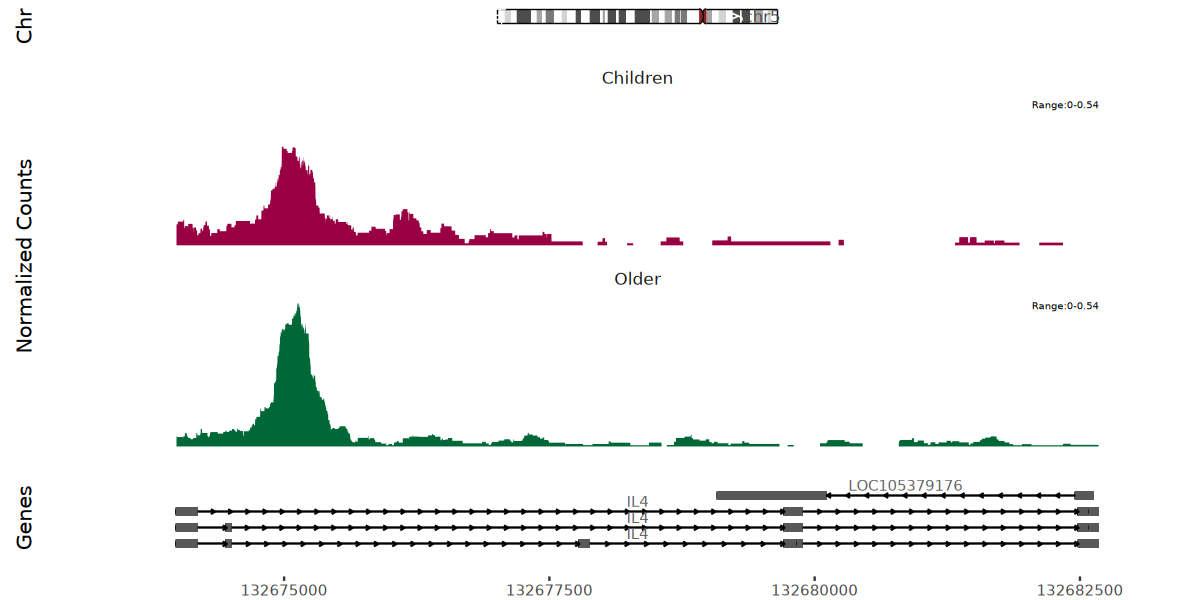

In [14]:
options(repr.plot.width = 10, repr.plot.height = 5)

ifng <- getbpCounts(regionString = "chr5:132,673,986-132,682,676", 
                    popFrags = pop_frags, numCores = 16)
plotRegion(countdf = ifng,
           ArchRProj = projHeme1_subset, 
           counts_group_colors = c('#980043',
                                   '#006837'))

Warning message in all(lapply(seq_along(tmpCounts), function(x) {:
"coercing argument of type 'list' to logical"
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message in !vapply(ggl, fixed, logical(1L)) & !vapply(PlotList, is, "Ideogram", :
"longer object length is not a multiple of shorter object length"


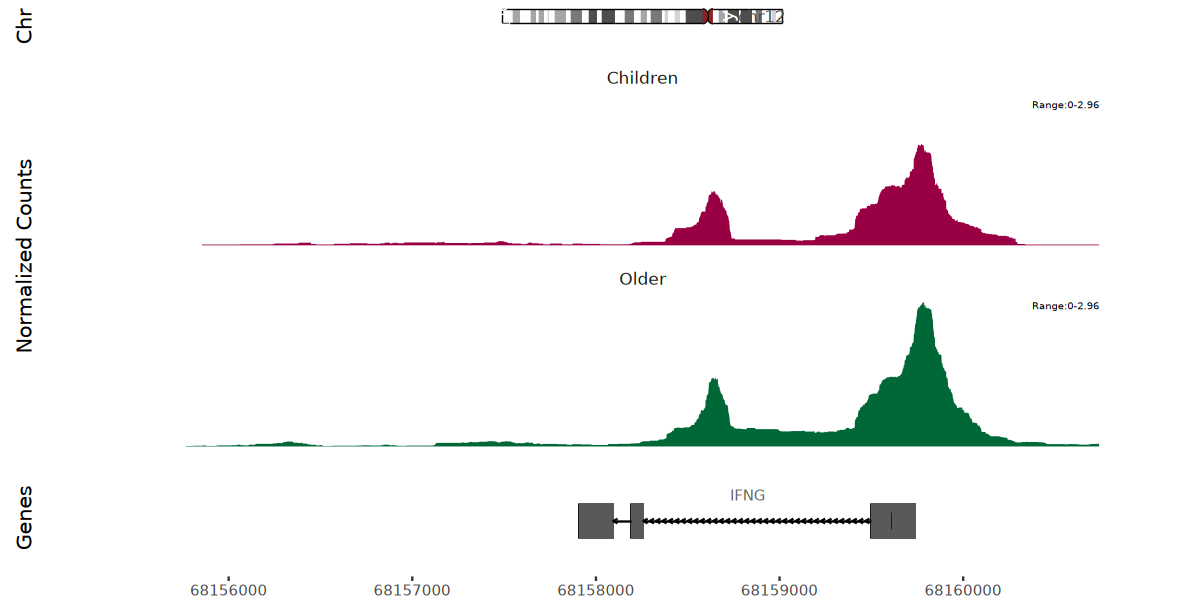

In [24]:
ifng <- getbpCounts(regionString = "chr12:68,155,768-68,160,740", 
                    popFrags = pop_frags, numCores = 16)
plotRegion(countdf = ifng,
           ArchRProj = projHeme1_subset, 
           counts_group_colors = c('#980043',
                                   '#006837'))

Warning message in all(lapply(seq_along(tmpCounts), function(x) {:
"coercing argument of type 'list' to logical"
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message in !vapply(ggl, fixed, logical(1L)) & !vapply(PlotList, is, "Ideogram", :
"longer object length is not a multiple of shorter object length"


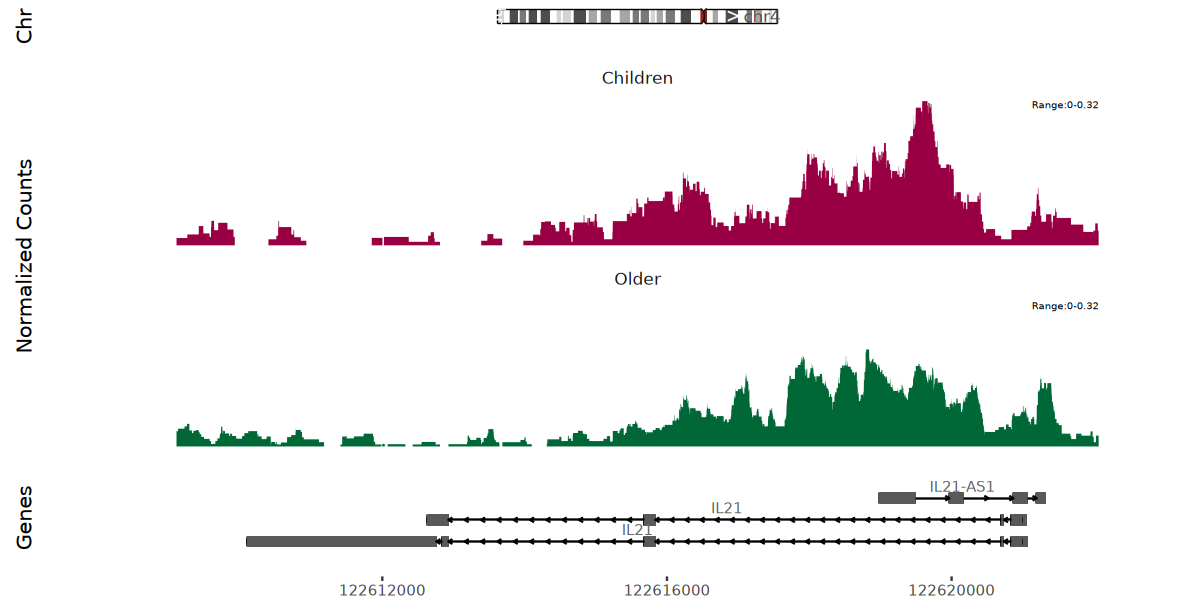

In [26]:
ifng <- getbpCounts(regionString = "chr4:122,609,108-122,622,066", 
                    popFrags = pop_frags, numCores = 16)
plotRegion(countdf = ifng,
           ArchRProj = projHeme1_subset, 
           counts_group_colors = c('#980043',
                                   '#006837'))

Warning message in all(lapply(seq_along(tmpCounts), function(x) {:
"coercing argument of type 'list' to logical"
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message in !vapply(ggl, fixed, logical(1L)) & !vapply(PlotList, is, "Ideogram", :
"longer object length is not a multiple of shorter object length"


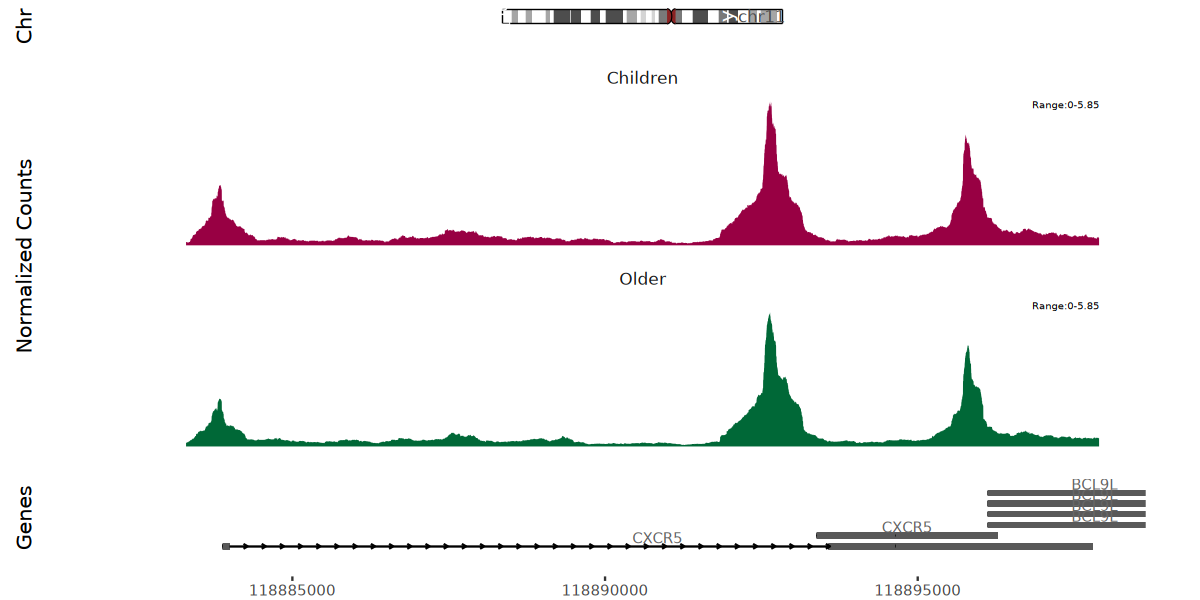

In [35]:
ifng <- getbpCounts(regionString = "chr11:118,883,300-118,897,900", 
                    popFrags = pop_frags, numCores = 16)
plotRegion(countdf = ifng,
           ArchRProj = projHeme1_subset, 
           counts_group_colors = c('#980043',
                                   '#006837'))

Warning message in all(lapply(seq_along(tmpCounts), function(x) {:
"coercing argument of type 'list' to logical"


[1] "Size of region exceeds 1e+05bp. Binning data over 250bp windows."


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message in !vapply(ggl, fixed, logical(1L)) & !vapply(PlotList, is, "Ideogram", :
"longer object length is not a multiple of shorter object length"


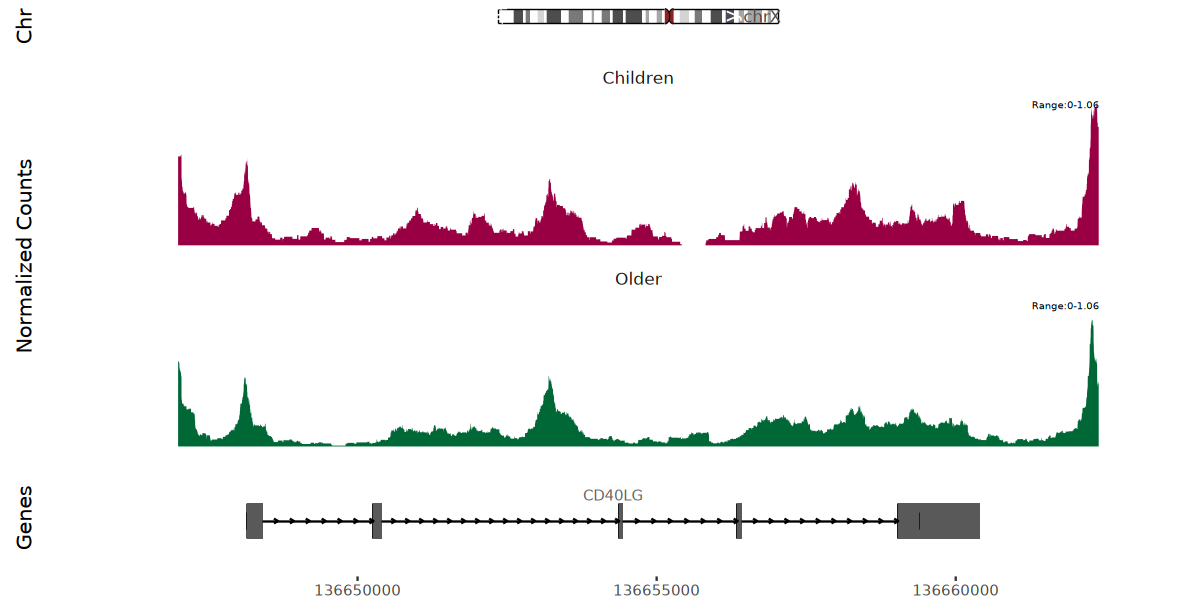

In [32]:
ifng <- getbpCounts(regionString = "chrX:136,647,000-136,662,390", 
                    popFrags = pop_frags, 
                    numCores = 16)
plotRegion(countdf = ifng,
           ArchRProj = projHeme1_subset, 
           counts_group_colors = c('#980043',
                                   '#006837'))